# 📊 Análisis Exploratorio de Datos (EDA) - Comentarios Tóxicos de YouTube

Este notebook contiene el análisis exploratorio de datos para el proyecto de detección de comentarios de odio en YouTube.

## 📋 Objetivos del EDA:
 - Explorar la estructura y calidad de los datos
 - Analizar la distribución de las diferentes categorías de toxicidad
 - Identificar patrones en los comentarios tóxicos vs no tóxicos
 - Detectar posibles desequilibrios en las clases
 - Análisis de texto: longitud, palabras más frecuentes, etc.
 - Identificar insights para el preprocesamiento y modelado

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Análisis del dataset

### 1. Carga y Exploración Inicial de los Datos

Esta sección carga el dataset y proporciona una primera vista de la estructura, dimensiones y tipos de datos. Es fundamental para entender con qué información contamos y detectar posibles problemas de calidad de datos desde el inicio.

In [3]:
df = pd.read_csv('../data/youtoxic_english_1000.csv')

print("🔍 INFORMACIÓN BÁSICA DEL DATASET")
print("="*50)
print(f"📊 Forma del dataset: {df.shape}")
print(f"📝 Número de comentarios: {df.shape[0]:,}")
print(f"🏷️ Número de características: {df.shape[1]}")

🔍 INFORMACIÓN BÁSICA DEL DATASET
📊 Forma del dataset: (1000, 15)
📝 Número de comentarios: 1,000
🏷️ Número de características: 15


In [4]:
print("\n📋 PRIMERAS 5 FILAS DEL DATASET:")
print("="*50)
df.head()


📋 PRIMERAS 5 FILAS DEL DATASET:


,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False,False,False,False,False
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False


In [5]:
print("\n📊 INFORMACIÓN GENERAL:")
print("="*50)
df.info()


📊 INFORMACIÓN GENERAL:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CommentId        1000 non-null   object
 1   VideoId          1000 non-null   object
 2   Text             1000 non-null   object
 3   IsToxic          1000 non-null   bool  
 4   IsAbusive        1000 non-null   bool  
 5   IsThreat         1000 non-null   bool  
 6   IsProvocative    1000 non-null   bool  
 7   IsObscene        1000 non-null   bool  
 8   IsHatespeech     1000 non-null   bool  
 9   IsRacist         1000 non-null   bool  
 10  IsNationalist    1000 non-null   bool  
 11  IsSexist         1000 non-null   bool  
 12  IsHomophobic     1000 non-null   bool  
 13  IsReligiousHate  1000 non-null   bool  
 14  IsRadicalism     1000 non-null   bool  
dtypes: bool(12), object(3)
memory usage: 35.3+ KB


In [6]:
print("\n📈 ESTADÍSTICAS DESCRIPTIVAS:")
print("="*50)
df.describe()


📈 ESTADÍSTICAS DESCRIPTIVAS:


,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,1000,13,997,2,2,2,2,2,2,2,2,2,1,2,1
top,Ugg2KwwX0V8-aXgCoAEC,9pr1oE34bIM,run them over,False,False,False,False,False,False,False,False,False,False,False,False
freq,1,274,3,538,647,979,839,900,862,875,992,999,1000,988,1000


### 2. Análisis de las Etiquetas de Toxicidad

Aquí identificamos qué etiquetas de toxicidad tienen suficientes datos para realizar un análisis estadísticamente válido. Excluimos aquellas con muy pocos casos positivos ya que no permitirían entrenar modelos robustos.

In [7]:
# Identificar las columnas de etiquetas (excluyendo metadatos y columnas con información insuficiente)
label_columns = [col for col in df.columns if col not in ['CommentId', 'VideoId', 'Text', 'index']]

# Identificar etiquetas con datos insuficientes para análisis
insufficient_labels = []
for col in label_columns:
    true_count = (df[col] == True).sum()
    if true_count <= 1:  # Menos de 2 casos positivos
        insufficient_labels.append(col)

# Filtrar etiquetas con datos suficientes para análisis
analysis_labels = [col for col in label_columns if col not in insufficient_labels]

print(f"🔍 Etiquetas identificadas: {label_columns}")
print(f"🔍 Etiquetas con datos insuficientes (≤1 casos): {insufficient_labels}")
print(f"🔍 Etiquetas para análisis: {analysis_labels}")
print(f"🔍 Total de etiquetas para análisis: {len(analysis_labels)}")

🔍 Etiquetas identificadas: ['IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist', 'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']
🔍 Etiquetas con datos insuficientes (≤1 casos): ['IsSexist', 'IsHomophobic', 'IsRadicalism']
🔍 Etiquetas para análisis: ['IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsReligiousHate']
🔍 Total de etiquetas para análisis: 9


In [8]:
# Análisis de distribución de cada etiqueta
print("\n📊 DISTRIBUCIÓN DE ETIQUETAS:")
print("="*50)

label_stats = {}
for col in analysis_labels:
    true_count = (df[col] == True).sum()
    false_count = (df[col] == False).sum()
    true_pct = (true_count / len(df)) * 100
    
    label_stats[col] = {
        'True': true_count,
        'False': false_count,
        'True_pct': true_pct
    }
    
    print(f"{col}:")
    print(f"  ✅ True: {true_count:,} ({true_pct:.2f}%)")
    print(f"  ❌ False: {false_count:,} ({100-true_pct:.2f}%)")
    print()

if insufficient_labels:
    print("⚠️ ETIQUETAS EXCLUIDAS DEL ANÁLISIS:")
    print("="*50)
    for col in insufficient_labels:
        true_count = (df[col] == True).sum()
        print(f"{col}: Solo {true_count} caso(s) positivo(s) - Insuficiente para análisis")



📊 DISTRIBUCIÓN DE ETIQUETAS:
IsToxic:
  ✅ True: 462 (46.20%)
  ❌ False: 538 (53.80%)

IsAbusive:
  ✅ True: 353 (35.30%)
  ❌ False: 647 (64.70%)

IsThreat:
  ✅ True: 21 (2.10%)
  ❌ False: 979 (97.90%)

IsProvocative:
  ✅ True: 161 (16.10%)
  ❌ False: 839 (83.90%)

IsObscene:
  ✅ True: 100 (10.00%)
  ❌ False: 900 (90.00%)

IsHatespeech:
  ✅ True: 138 (13.80%)
  ❌ False: 862 (86.20%)

IsRacist:
  ✅ True: 125 (12.50%)
  ❌ False: 875 (87.50%)

IsNationalist:
  ✅ True: 8 (0.80%)
  ❌ False: 992 (99.20%)

IsReligiousHate:
  ✅ True: 12 (1.20%)
  ❌ False: 988 (98.80%)

⚠️ ETIQUETAS EXCLUIDAS DEL ANÁLISIS:
IsSexist: Solo 1 caso(s) positivo(s) - Insuficiente para análisis
IsHomophobic: Solo 0 caso(s) positivo(s) - Insuficiente para análisis
IsRadicalism: Solo 0 caso(s) positivo(s) - Insuficiente para análisis


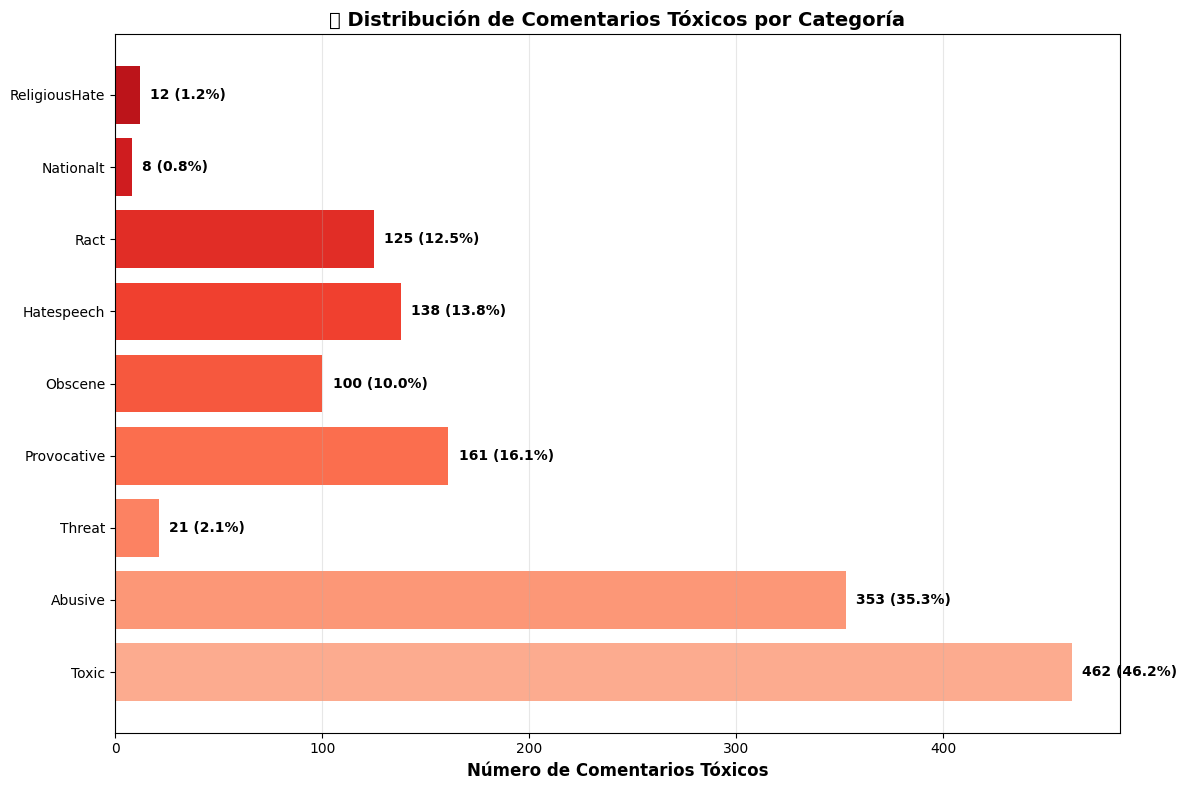

In [9]:
# Crear un gráfico de barras horizontal para mejor visualización
plt.figure(figsize=(12, 8))

# Preparar datos para el gráfico
labels = []
true_counts = []
percentages = []

for col in analysis_labels:
    labels.append(col.replace('Is', '').replace('is', ''))
    true_count = (df[col] == True).sum()
    true_counts.append(true_count)
    percentages.append((true_count / len(df)) * 100)

# Crear gráfico de barras horizontal
bars = plt.barh(labels, true_counts, color=plt.cm.Reds(np.linspace(0.3, 0.8, len(labels))))

# Añadir etiquetas con porcentajes
for i, (count, pct) in enumerate(zip(true_counts, percentages)):
    plt.text(count + 5, i, f'{count} ({pct:.1f}%)', 
             va='center', fontweight='bold', fontsize=10)

plt.xlabel('Número de Comentarios Tóxicos', fontsize=12, fontweight='bold')
plt.title('📊 Distribución de Comentarios Tóxicos por Categoría', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 3. Análisis de Correlaciones entre Etiquetas

Este análisis identifica qué tipos de toxicidad tienden a aparecer juntos en los comentarios. Las correlaciones altas pueden indicar redundancia entre etiquetas o patrones de comportamiento tóxico específicos.

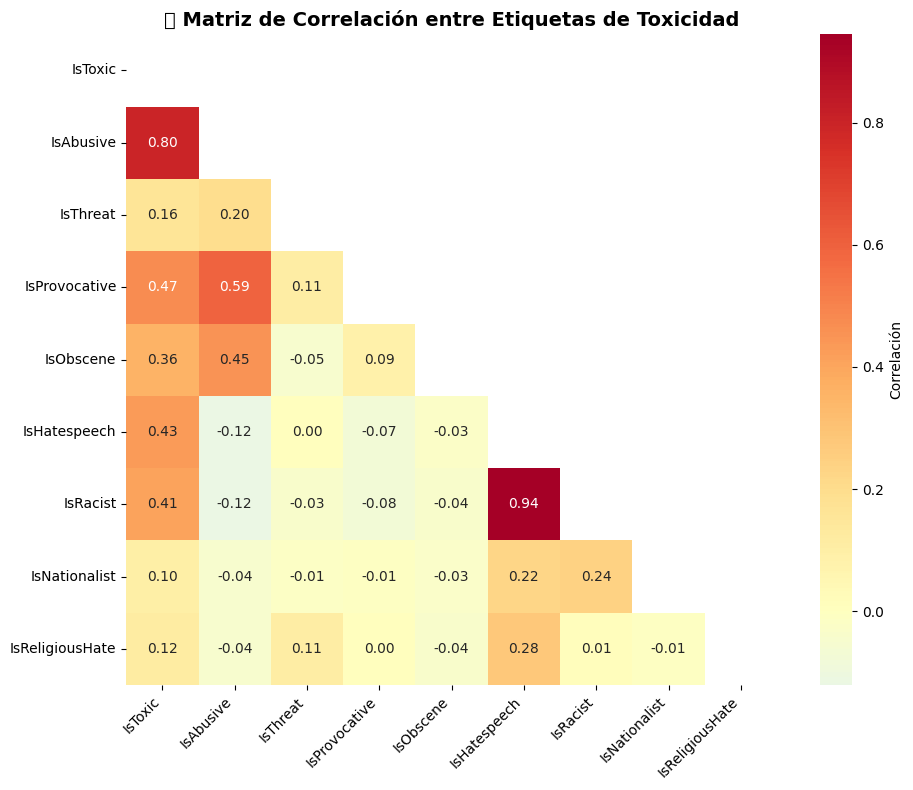

In [10]:
# Matriz de correlación entre etiquetas (solo las que tienen datos suficientes)
correlation_matrix = df[analysis_labels].corr()

# Visualizar matriz de correlación
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix,
            annot=True,
            cmap='RdYlBu_r',
            center=0,
            square=True,
            mask=mask,
            cbar_kws={'label': 'Correlación'},
            fmt='.2f')

plt.title('🔍 Matriz de Correlación entre Etiquetas de Toxicidad', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [11]:
# Obtener correlaciones sin la diagonal
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_pairs.append({
            'Label1': correlation_matrix.columns[i],
            'Label2': correlation_matrix.columns[j],
            'Correlation': correlation_matrix.iloc[i, j]
        })

# Ordenar por correlación absoluta
corr_df = pd.DataFrame(corr_pairs)
corr_df['Abs_Correlation'] = corr_df['Correlation'].abs()
corr_df = corr_df.sort_values('Abs_Correlation', ascending=False)

print("Top 10 correlaciones más fuertes:")
for _, row in corr_df.head(10).iterrows():
    print(f"  {row['Label1']} ↔ {row['Label2']}: {row['Correlation']:.3f}")

Top 10 correlaciones más fuertes:
  IsHatespeech ↔ IsRacist: 0.945
  IsToxic ↔ IsAbusive: 0.797
  IsAbusive ↔ IsProvocative: 0.593
  IsToxic ↔ IsProvocative: 0.473
  IsAbusive ↔ IsObscene: 0.451
  IsToxic ↔ IsHatespeech: 0.432
  IsToxic ↔ IsRacist: 0.408
  IsToxic ↔ IsObscene: 0.360
  IsHatespeech ↔ IsReligiousHate: 0.275
  IsRacist ↔ IsNationalist: 0.238


# Análisis de Texto

Esta sección examina las características textuales de los comentarios para entender patrones de longitud y vocabulario que puedan ser útiles para la clasificación. También identifica diferencias entre comentarios tóxicos y no tóxicos.

In [12]:
# Análisis básico de longitud de texto
print("📝 ANÁLISIS DE LONGITUD DE COMENTARIOS:")
print("="*50)

# Calcular estadísticas de longitud
df['text_length'] = df['Text'].str.len()
df['word_count'] = df['Text'].str.split().str.len()

print("Estadísticas de longitud de caracteres:")
print(df['text_length'].describe())
print("\nEstadísticas de número de palabras:")
print(df['word_count'].describe())

📝 ANÁLISIS DE LONGITUD DE COMENTARIOS:
Estadísticas de longitud de caracteres:
count    1000.000000
mean      185.554000
std       270.780777
min         3.000000
25%        47.000000
50%       101.000000
75%       217.000000
max      4421.000000
Name: text_length, dtype: float64

Estadísticas de número de palabras:
count    1000.000000
mean       33.776000
std        49.069498
min         1.000000
25%         9.000000
50%        19.000000
75%        39.000000
max       815.000000
Name: word_count, dtype: float64


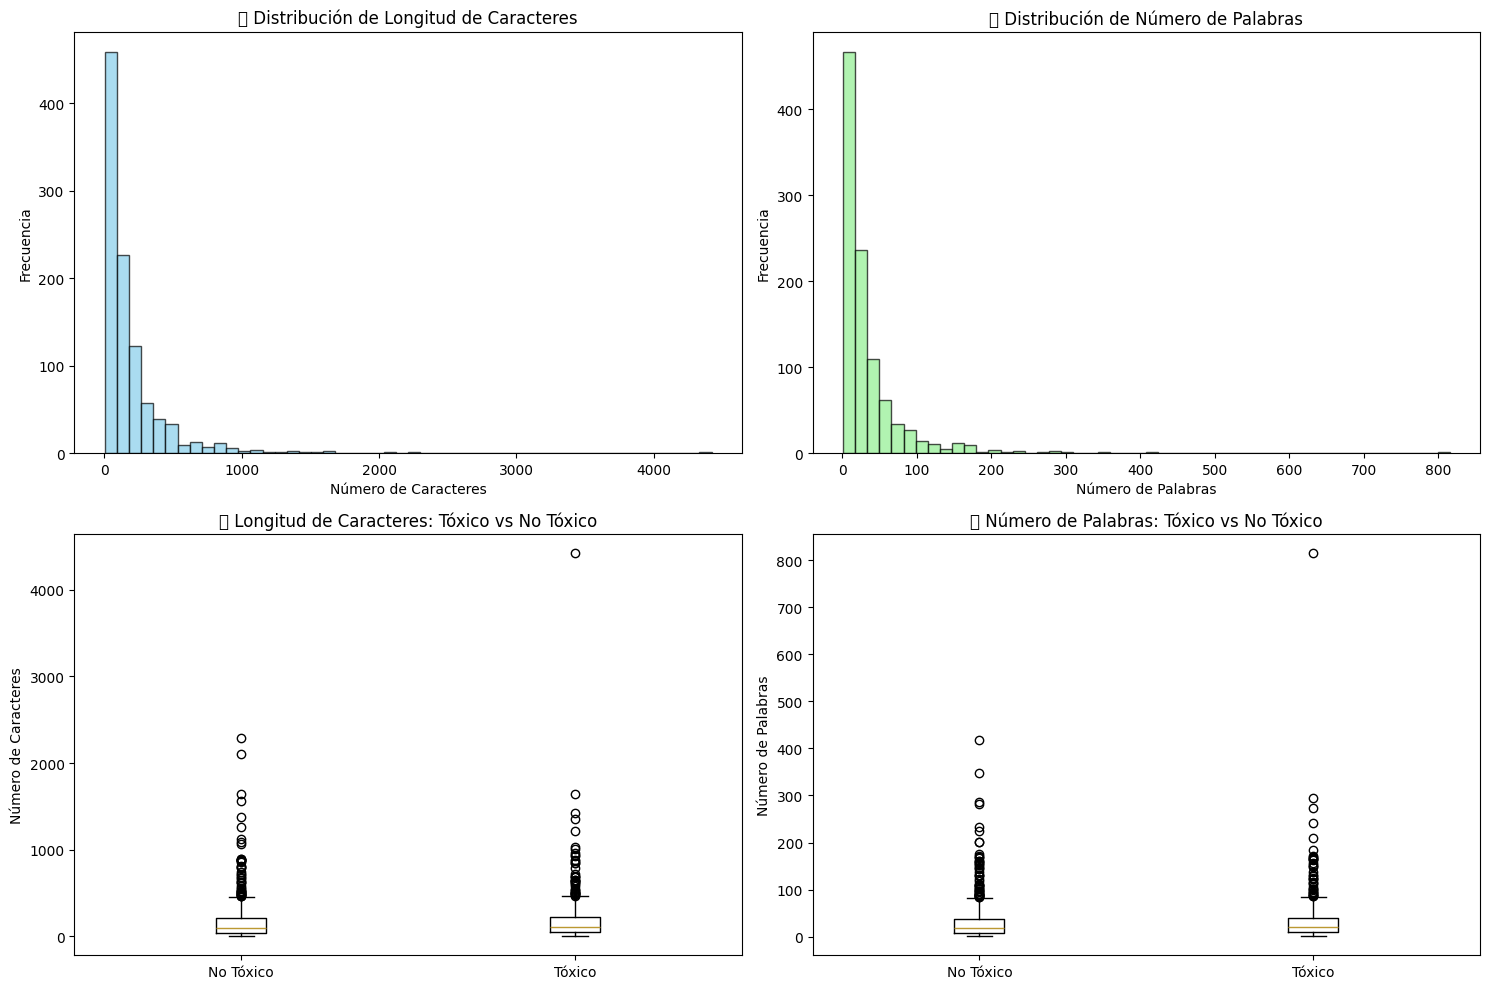

In [13]:
# Visualización de distribución de longitudes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribución de longitud de caracteres
axes[0,0].hist(df['text_length'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('📏 Distribución de Longitud de Caracteres')
axes[0,0].set_xlabel('Número de Caracteres')
axes[0,0].set_ylabel('Frecuencia')

# Distribución de número de palabras
axes[0,1].hist(df['word_count'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('📝 Distribución de Número de Palabras')
axes[0,1].set_xlabel('Número de Palabras')
axes[0,1].set_ylabel('Frecuencia')

# Boxplot de longitud por toxicidad general
# Crear una columna de toxicidad general (si cualquier etiqueta es True)
df['is_toxic'] = df[analysis_labels].any(axis=1)

axes[1,0].boxplot([df[df['is_toxic'] == False]['text_length'], 
                   df[df['is_toxic'] == True]['text_length']], 
                  labels=['No Tóxico', 'Tóxico'])
axes[1,0].set_title('📊 Longitud de Caracteres: Tóxico vs No Tóxico')
axes[1,0].set_ylabel('Número de Caracteres')

# Boxplot de palabras por toxicidad general
axes[1,1].boxplot([df[df['is_toxic'] == False]['word_count'], 
                   df[df['is_toxic'] == True]['word_count']], 
                  labels=['No Tóxico', 'Tóxico'])
axes[1,1].set_title('📊 Número de Palabras: Tóxico vs No Tóxico')
axes[1,1].set_ylabel('Número de Palabras')

plt.tight_layout()
plt.show()

In [14]:
# Análisis de palabras más frecuentes
from collections import Counter
import re

def clean_text_for_analysis(text):
    """Limpia el texto para análisis de frecuencia"""
    # Convertir a minúsculas y eliminar caracteres especiales
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    return text

print("🔤 ANÁLISIS DE PALABRAS MÁS FRECUENTES:")
print("="*50)

# Palabras más frecuentes en comentarios no tóxicos
non_toxic_texts = df[df['is_toxic'] == False]['Text'].fillna('')
non_toxic_words = []
for text in non_toxic_texts:
    non_toxic_words.extend(clean_text_for_analysis(text).split())

# Palabras más frecuentes en comentarios tóxicos
toxic_texts = df[df['is_toxic'] == True]['Text'].fillna('')
toxic_words = []
for text in toxic_texts:
    toxic_words.extend(clean_text_for_analysis(text).split())

# Filtrar palabras vacías comunes
common_stopwords = {
    'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by',
    'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did',
    'will', 'would', 'could', 'should', 'may', 'might', 'must', 'can', 'cant', 'cannot',
    'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them',
    'my', 'your', 'his', 'her', 'its', 'our', 'their', 'this', 'that', 'these', 'those',
    'if', 'then', 'else', 'when', 'where', 'why', 'how', 'what', 'who', 'which', 'whose',
    'there', 'here', 'now', 'then', 'also', 'just', 'only', 'even', 'still', 'more', 'most',
    'some', 'any', 'all', 'no', 'not', 'so', 'too', 'very', 'much', 'many', 'few', 'little',
    'about', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'up', 'down',
    'out', 'off', 'over', 'under', 'again', 'further', 'once', 'other', 'such', 'own', 'same',
    'get', 'got', 'go', 'going', 'come', 'came', 'see', 'saw', 'know', 'knew', 'think', 'thought',
    'say', 'said', 'make', 'made', 'take', 'took', 'give', 'gave', 'put', 'use', 'used', 'find',
    'want', 'need', 'work', 'way', 'new', 'good', 'bad', 'right', 'wrong', 'big', 'small',
    'long', 'short', 'high', 'low', 'old', 'young', 'early', 'late', 'first', 'last', 'next',
    'dont', 'doesnt', 'didnt', 'wont', 'wouldnt', 'shouldnt', 'couldnt', 'isnt', 'arent', 'wasnt', 'werent',
    'im', 'youre', 'hes', 'shes', 'its', 'were', 'theyre', 'ive', 'youve', 'weve', 'theyve',
    'like', 'thats', 'youll', 'hell', 'shell', 'well', 'theyll'
}

non_toxic_words = [word for word in non_toxic_words if word not in common_stopwords and len(word) > 2]
toxic_words = [word for word in toxic_words if word not in common_stopwords and len(word) > 2]

print("Top 15 palabras en comentarios NO TÓXICOS:")
non_toxic_freq = Counter(non_toxic_words).most_common(15)
for word, count in non_toxic_freq:
    print(f"  {word}: {count}")

print("\nTop 15 palabras en comentarios TÓXICOS:")
toxic_freq = Counter(toxic_words).most_common(15)
for word, count in toxic_freq:
    print(f"  {word}: {count}")

🔤 ANÁLISIS DE PALABRAS MÁS FRECUENTES:
Top 15 palabras en comentarios NO TÓXICOS:
  people: 129
  black: 116
  police: 103
  officer: 59
  white: 59
  video: 58
  brown: 54
  cop: 49
  shot: 44
  one: 43
  from: 43
  because: 42
  cops: 35
  man: 32
  truth: 31

Top 15 palabras en comentarios TÓXICOS:
  black: 130
  people: 127
  white: 76
  police: 72
  brown: 50
  fuck: 50
  shot: 48
  because: 47
  from: 45
  shit: 44
  one: 39
  officer: 38
  cop: 37
  man: 35
  cops: 34


## 5. Análisis de Desequilibrio de Clases

El desequilibrio de clases es crítico en problemas de clasificación. Esta sección cuantifica el desequilibrio para cada etiqueta, información esencial para seleccionar las técnicas de modelado y métricas de evaluación apropiadas.

In [15]:
print("⚖️ ANÁLISIS DE DESEQUILIBRIO DE CLASES:")
print("="*50)

# Análisis general de toxicidad
toxic_count = df['is_toxic'].sum()
non_toxic_count = len(df) - toxic_count
toxic_ratio = toxic_count / len(df)

print(f"📊 Comentarios tóxicos: {toxic_count:,} ({toxic_ratio:.2%})")
print(f"📊 Comentarios no tóxicos: {non_toxic_count:,} ({1-toxic_ratio:.2%})")
print(f"📊 Ratio de desequilibrio: {non_toxic_count/toxic_count:.2f}:1")

# Análisis por cada etiqueta (solo las que se van a usar)
print("\n🔍 Desequilibrio por etiqueta (solo etiquetas válidas para análisis):")
for col in analysis_labels:
    positive_count = (df[col] == True).sum()
    negative_count = (df[col] == False).sum()
    ratio = negative_count / positive_count if positive_count > 0 else float('inf')
    print(f"  {col}: {ratio:.2f}:1 (False:True)")

⚖️ ANÁLISIS DE DESEQUILIBRIO DE CLASES:
📊 Comentarios tóxicos: 462 (46.20%)
📊 Comentarios no tóxicos: 538 (53.80%)
📊 Ratio de desequilibrio: 1.16:1

🔍 Desequilibrio por etiqueta (solo etiquetas válidas para análisis):
  IsToxic: 1.16:1 (False:True)
  IsAbusive: 1.83:1 (False:True)
  IsThreat: 46.62:1 (False:True)
  IsProvocative: 5.21:1 (False:True)
  IsObscene: 9.00:1 (False:True)
  IsHatespeech: 6.25:1 (False:True)
  IsRacist: 7.00:1 (False:True)
  IsNationalist: 124.00:1 (False:True)
  IsReligiousHate: 82.33:1 (False:True)


## 6. Análisis de Comentarios Multi-etiqueta

Este análisis examina cuántos comentarios tienen múltiples tipos de toxicidad simultáneamente. Es importante para decidir entre enfoques de clasificación multi-etiqueta o binarios independientes.

In [16]:
print("🏷️ ANÁLISIS DE COMENTARIOS MULTI-ETIQUETA:")
print("="*50)

# Contar cuántas etiquetas positivas tiene cada comentario
df['num_toxic_labels'] = df[analysis_labels].sum(axis=1)

# Distribución de número de etiquetas por comentario
label_distribution = df['num_toxic_labels'].value_counts().sort_index()
print("Distribución de número de etiquetas tóxicas por comentario:")
for num_labels, count in label_distribution.items():
    percentage = (count / len(df)) * 100
    print(f"  {num_labels} etiquetas: {count:,} comentarios ({percentage:.2f}%)")

🏷️ ANÁLISIS DE COMENTARIOS MULTI-ETIQUETA:
Distribución de número de etiquetas tóxicas por comentario:
  0 etiquetas: 538 comentarios (53.80%)
  2 etiquetas: 100 comentarios (10.00%)
  3 etiquetas: 294 comentarios (29.40%)
  4 etiquetas: 48 comentarios (4.80%)
  5 etiquetas: 14 comentarios (1.40%)
  6 etiquetas: 6 comentarios (0.60%)


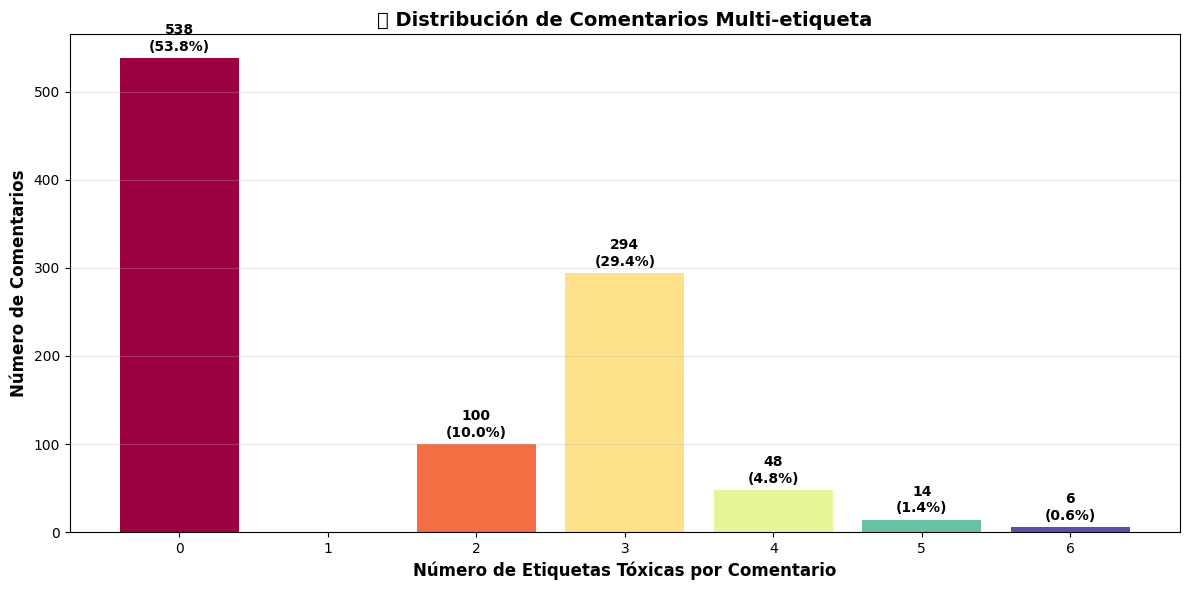

In [17]:
# Visualización de comentarios multi-etiqueta
plt.figure(figsize=(12, 6))

# Gráfico de barras
bars = plt.bar(label_distribution.index, label_distribution.values, 
               color=plt.cm.Spectral(np.linspace(0, 1, len(label_distribution))))

# Añadir etiquetas con porcentajes
for bar, count in zip(bars, label_distribution.values):
    height = bar.get_height()
    percentage = (count / len(df)) * 100
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{count}\n({percentage:.1f}%)', 
             ha='center', va='bottom', fontweight='bold')

plt.xlabel('Número de Etiquetas Tóxicas por Comentario', fontsize=12, fontweight='bold')
plt.ylabel('Número de Comentarios', fontsize=12, fontweight='bold')
plt.title('🏷️ Distribución de Comentarios Multi-etiqueta', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Resumen de Insights y Recomendaciones

Esta sección consolida los hallazgos principales del EDA y proporciona recomendaciones específicas para las fases posteriores de preprocesamiento y modelado.

In [18]:
print("🔍 INSIGHTS PRINCIPALES DEL EDA:")
print("="*60)

print("\n🔍 1. ESTRUCTURA DE DATOS:")
print(f"   • Dataset con {len(df):,} comentarios y {len(analysis_labels)} etiquetas de toxicidad válidas")
print(f"   • Etiquetas válidas: {', '.join(analysis_labels)}")
if insufficient_labels:
    print(f"   • Etiquetas excluidas por datos insuficientes: {', '.join(insufficient_labels)}")

print("\n⚖️ 2. DESEQUILIBRIO DE CLASES:")
print(f"   • {toxic_ratio:.1%} de comentarios son tóxicos en general")
print("   • Todas las etiquetas muestran fuerte desequilibrio (mayoría de casos negativos)")
print("   • Esto requerirá técnicas de balanceamiento o métricas especiales")

print("\n🔍 3. CORRELACIONES:")
if len(corr_df) > 0:
    strongest_corr = corr_df.iloc[0]
    print(f"   • Correlación más fuerte: {strongest_corr['Label1']} ↔ {strongest_corr['Label2']} ({strongest_corr['Correlation']:.3f})")
print("   • Algunas etiquetas están correlacionadas, considerar esto en el modelado")

print("\n🔍 4. CARACTERÍSTICAS DEL TEXTO:")
print(f"   • Longitud promedio: {df['text_length'].mean():.0f} caracteres")
print(f"   • Número promedio de palabras: {df['word_count'].mean():.1f}")
multi_label_pct = (df['num_toxic_labels'] > 1).sum() / len(df) * 100
print(f"   • {multi_label_pct:.1f}% de comentarios tóxicos tienen múltiples etiquetas")

print("\n🔍 5. RECOMENDACIONES PARA EL MODELADO:")
print("   • Usar métricas apropiadas para datos desequilibrados (F1, ROC-AUC, Precision-Recall)")
print("   • Considerar técnicas de balanceamiento (SMOTE, class_weight, etc.)")
print("   • Implementar validación estratificada")
print("   • Evaluar modelos multi-etiqueta vs binarios independientes")
print("   • Preprocesar texto: lowercasing, eliminación de caracteres especiales, etc.")
print("   • Considerar features de longitud de texto como variables adicionales")
if insufficient_labels:
    print(f"   • Excluir del modelado las etiquetas: {', '.join(insufficient_labels)} por falta de datos")

# Guardar algunas estadísticas clave para uso posterior
stats_summary = {
    'total_comments': len(df),
    'toxic_ratio': toxic_ratio,
    'valid_label_columns': analysis_labels,
    'excluded_labels': insufficient_labels,
    'avg_text_length': df['text_length'].mean(),
    'avg_word_count': df['word_count'].mean(),
    'multi_label_ratio': multi_label_pct / 100
}

print(f"\n🔍 Estadísticas guardadas para referencia futura:")
for key, value in stats_summary.items():
    print(f"   {key}: {value}")

🔍 INSIGHTS PRINCIPALES DEL EDA:

🔍 1. ESTRUCTURA DE DATOS:
   • Dataset con 1,000 comentarios y 9 etiquetas de toxicidad válidas
   • Etiquetas válidas: IsToxic, IsAbusive, IsThreat, IsProvocative, IsObscene, IsHatespeech, IsRacist, IsNationalist, IsReligiousHate
   • Etiquetas excluidas por datos insuficientes: IsSexist, IsHomophobic, IsRadicalism

⚖️ 2. DESEQUILIBRIO DE CLASES:
   • 46.2% de comentarios son tóxicos en general
   • Todas las etiquetas muestran fuerte desequilibrio (mayoría de casos negativos)
   • Esto requerirá técnicas de balanceamiento o métricas especiales

🔍 3. CORRELACIONES:
   • Correlación más fuerte: IsHatespeech ↔ IsRacist (0.945)
   • Algunas etiquetas están correlacionadas, considerar esto en el modelado

🔍 4. CARACTERÍSTICAS DEL TEXTO:
   • Longitud promedio: 186 caracteres
   • Número promedio de palabras: 33.8
   • 46.2% de comentarios tóxicos tienen múltiples etiquetas

🔍 5. RECOMENDACIONES PARA EL MODELADO:
   • Usar métricas apropiadas para datos des

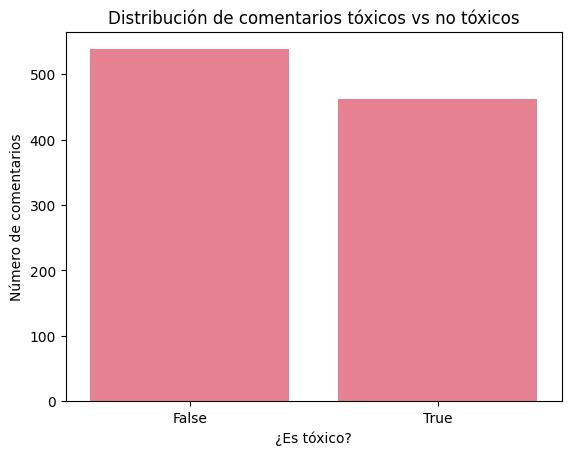

Distribución porcentual:
 IsToxic
False    53.8
True     46.2
Name: proportion, dtype: float64


In [19]:
# Distribución del target IsToxic
sns.countplot(x="IsToxic", data=df)
plt.title("Distribución de comentarios tóxicos vs no tóxicos")
plt.xlabel("¿Es tóxico?")
plt.ylabel("Número de comentarios")
plt.show()

# Porcentaje de cada clase
toxicity_ratio = df["IsToxic"].value_counts(normalize=True) * 100
print("Distribución porcentual:\n", toxicity_ratio)


In [20]:
# Crear columnas nuevas para análisis de texto
df["text_length_chars"] = df["Text"].apply(len)
df["text_length_words"] = df["Text"].apply(lambda x: len(x.split()))

# Mostrar estadísticos por tipo de comentario
df.groupby("IsToxic")[["text_length_chars", "text_length_words"]].describe()


text_length_chars                                                     \
                    count        mean         std  min    25%    50%     75%   
IsToxic                                                                        
False               538.0  182.262082  252.295702  3.0  44.00   96.0  210.75   
True                462.0  189.387446  291.061941  6.0  54.25  110.0  220.75   

                text_length_words                                         \
            max             count       mean        std  min   25%   50%   
IsToxic                                                                    
False    2292.0             538.0  33.065056  45.165137  1.0   8.0  18.0   
True     4421.0             462.0  34.603896  53.294876  1.0  10.0  20.0   

                      
          75%    max  
IsToxic               
False    38.0  418.0  
True     40.0  815.0

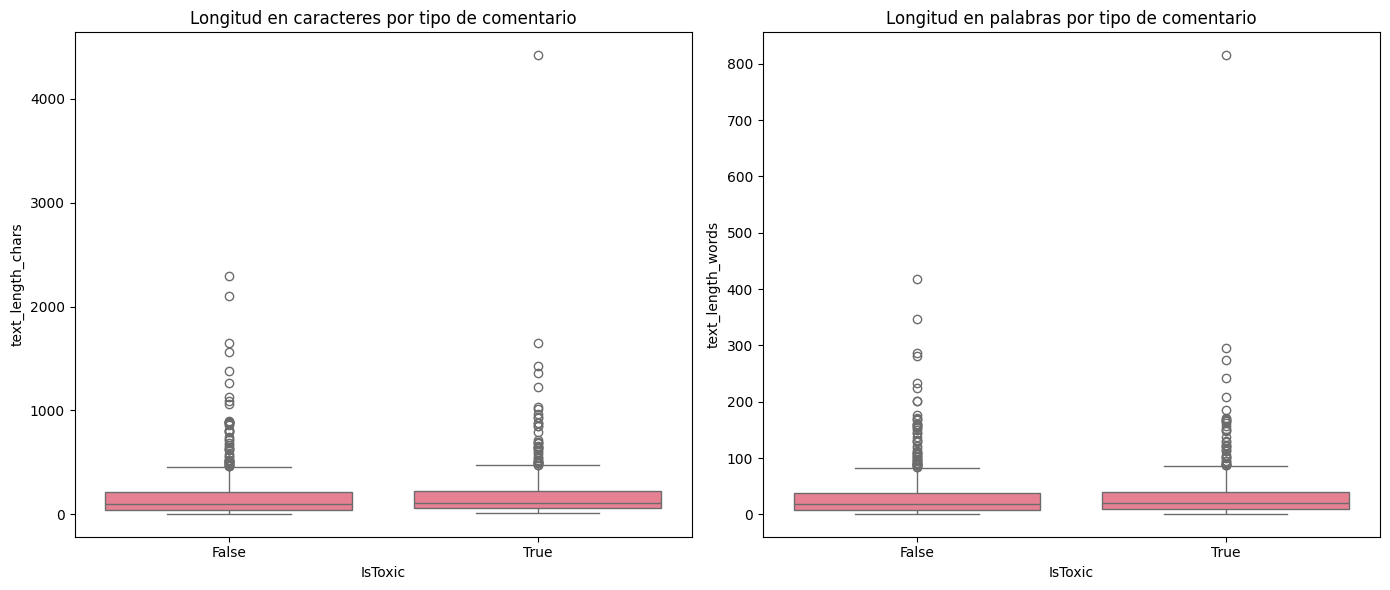

In [21]:
# Boxplots para comparar longitud de texto por clase
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(x="IsToxic", y="text_length_chars", data=df, ax=axes[0])
axes[0].set_title("Longitud en caracteres por tipo de comentario")

sns.boxplot(x="IsToxic", y="text_length_words", data=df, ax=axes[1])
axes[1].set_title("Longitud en palabras por tipo de comentario")

plt.tight_layout()
plt.show()


### Comparativa de longitud de los comentarios (Boxplot)

En esta visualización comparamos la **longitud de los comentarios tóxicos y no tóxicos**, tanto en número de caracteres como de palabras.

#### ¿Qué es un boxplot?
Un **boxplot** (o diagrama de caja) es una representación visual que nos permite ver:
- La **mediana** del conjunto de datos (línea central de la caja).
- El **rango intercuartílico** (donde se concentra el 50% de los valores).
- Los **valores extremos o outliers** (representados como puntos).

#### ¿Qué vemos en estos gráficos?
- La longitud de los comentarios **tóxicos y no tóxicos** es muy similar.
- Hay **muchos comentarios cortos** en ambos grupos.
- Aparecen **algunos comentarios muy largos** (outliers), especialmente en caracteres.
- No se observa una diferencia clara que nos permita decir que un tipo de comentario sea más largo que otro de forma sistemática.

#### ¿Qué concluimos?
Aunque puede haber pequeñas diferencias, **la longitud del comentario no parece ser un buen indicador por sí solo de si un comentario es tóxico o no**. Aun así, es útil conocer estas características para posibles decisiones de preprocesamiento, como filtrar comentarios excesivamente largos o cortos.


In [22]:
# Filtrar comentarios tóxicos y no tóxicos
toxic_comments = df[df["IsToxic"] == True]["Text"]
nontoxic_comments = df[df["IsToxic"] == False]["Text"]

# Juntarlos en dos grandes textos para analizarlos
toxic_text = " ".join(toxic_comments).lower()
nontoxic_text = " ".join(nontoxic_comments).lower()


### Análisis del contenido textual

Para entender mejor las diferencias entre los comentarios tóxicos y no tóxicos, hemos separado los textos en dos grupos:

- Comentarios etiquetados como **tóxicos**.
- Comentarios etiquetados como **no tóxicos**.

Hemos unido los comentarios de cada grupo en un único texto para poder analizar qué palabras aparecen con mayor frecuencia en cada uno. Este enfoque nos permitirá visualizar patrones de lenguaje característicos, que luego pueden ser clave para entrenar un modelo predictivo.

En los próximos pasos generaremos:
- Listados de palabras más frecuentes.
- Nubes de palabras (*wordclouds*).
- N-gramas más comunes (combinaciones típicas de 2-3 palabras).


In [23]:
from collections import Counter
import re

# Función para limpiar texto básico (sin lematizar aún)
def limpiar_texto(texto):
    texto = re.sub(r"[^\w\s]", "", texto)  # quitar signos de puntuación
    texto = texto.lower()  # pasar a minúsculas
    return texto

# Aplicar limpieza y dividir en palabras
palabras_toxicas = limpiar_texto(toxic_text).split()
palabras_no_toxicas = limpiar_texto(nontoxic_text).split()

# Contar palabras más comunes
frecuentes_toxicas = Counter(palabras_toxicas).most_common(10)
frecuentes_no_toxicas = Counter(palabras_no_toxicas).most_common(10)

# Mostrar resultados
print("🔴 Palabras más frecuentes en comentarios tóxicos:")
for palabra, freq in frecuentes_toxicas:
    print(f"{palabra}: {freq}")

print("\n🟢 Palabras más frecuentes en comentarios no tóxicos:")
for palabra, freq in frecuentes_no_toxicas:
    print(f"{palabra}: {freq}")


🔴 Palabras más frecuentes en comentarios tóxicos:
the: 704
a: 395
and: 371
to: 370
of: 271
is: 232
you: 216
in: 194
that: 188
this: 181

🟢 Palabras más frecuentes en comentarios no tóxicos:
the: 841
to: 446
and: 441
a: 393
of: 331
is: 308
that: 271
in: 245
you: 242
i: 234


In [24]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

# Lista de stopwords en inglés
stop_words = set(stopwords.words("english"))

# Función mejorada que filtra stopwords
def limpiar_y_filtrar(texto):
    texto = re.sub(r"[^\w\s]", "", texto.lower())
    palabras = texto.split()
    return [p for p in palabras if p not in stop_words]

# Aplicar función mejorada
palabras_toxicas_filtradas = limpiar_y_filtrar(toxic_text)
palabras_no_toxicas_filtradas = limpiar_y_filtrar(nontoxic_text)

# Contar palabras más frecuentes (filtradas)
frecuentes_toxicas_filtradas = Counter(palabras_toxicas_filtradas).most_common(10)
frecuentes_no_toxicas_filtradas = Counter(palabras_no_toxicas_filtradas).most_common(10)

# Mostrar resultados
print("🔴 Palabras más frecuentes (tóxicos, sin stopwords):")
for palabra, freq in frecuentes_toxicas_filtradas:
    print(f"{palabra}: {freq}")

print("\n🟢 Palabras más frecuentes (no tóxicos, sin stopwords):")
for palabra, freq in frecuentes_no_toxicas_filtradas:
    print(f"{palabra}: {freq}")


🔴 Palabras más frecuentes (tóxicos, sin stopwords):
black: 130
people: 127
get: 79
white: 76
like: 75
police: 72
dont: 57
would: 57
brown: 50
fuck: 50

🟢 Palabras más frecuentes (no tóxicos, sin stopwords):
people: 129
black: 116
police: 103
like: 76
get: 64
would: 61
officer: 59
white: 59
video: 58
brown: 54


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/trabajo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Análisis con eliminación de stopwords

Las palabras más frecuentes que observamos inicialmente eran muy comunes y poco informativas. Por ello, hemos repetido el análisis **eliminando las stopwords**, es decir, palabras muy frecuentes en inglés que no aportan significado real (como "the", "and", "is", etc.).

Esta limpieza **no forma aún parte del preprocesamiento oficial**, pero se introduce aquí como una forma de enriquecer el EDA y tomar decisiones más informadas.

Ahora los resultados empiezan a revelar **patrones de contenido más relevantes** para entender qué vocabulario podría distinguir los comentarios tóxicos de los no tóxicos.


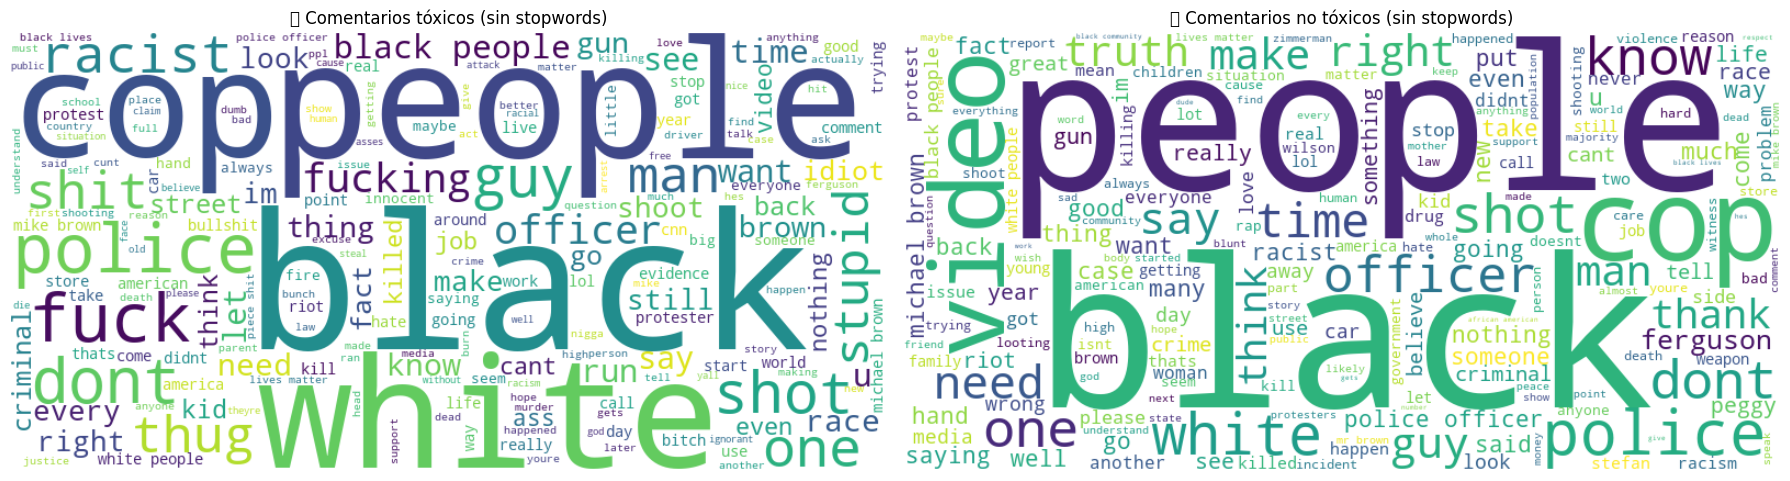

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Unir las palabras ya filtradas
texto_toxico_filtrado = " ".join(palabras_toxicas_filtradas)
texto_nontoxico_filtrado = " ".join(palabras_no_toxicas_filtradas)

# Crear las nubes
wc_toxico = WordCloud(width=800, height=400, background_color="white").generate(texto_toxico_filtrado)
wc_nontoxico = WordCloud(width=800, height=400, background_color="white").generate(texto_nontoxico_filtrado)

# Mostrar
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

axs[0].imshow(wc_toxico, interpolation="bilinear")
axs[0].axis("off")
axs[0].set_title("🔴 Comentarios tóxicos (sin stopwords)")

axs[1].imshow(wc_nontoxico, interpolation="bilinear")
axs[1].axis("off")
axs[1].set_title("🟢 Comentarios no tóxicos (sin stopwords)")

plt.tight_layout()
plt.show()


### WordClouds sin palabras vacías (stopwords)

Las siguientes nubes de palabras muestran los términos más repetidos en los comentarios **tóxicos** y **no tóxicos**, tras eliminar las palabras vacías típicas del inglés (como “the”, “and”, “is”…).

#### ¿Qué observamos?
- En los comentarios tóxicos aparecen con más frecuencia palabras como **“fuck”**, lo que indica un tono agresivo.
- También se observan términos raciales y relacionados con el orden público (**black, white, police**) en ambos grupos, lo que sugiere que el contexto es similar, pero el uso del lenguaje es lo que cambia.

Esta visualización permite a cualquier lector, incluso sin formación técnica, entender mejor el tipo de lenguaje que caracteriza cada grupo de comentarios.


In [26]:
from sklearn.feature_extraction.text import CountVectorizer

# Utilizamos los textos ya filtrados de stopwords
def mostrar_ngrams(textos, n=2, top=10):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(textos)
    suma = X.sum(axis=0)
    freqs = [(word, suma[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    freqs_sorted = sorted(freqs, key=lambda x: x[1], reverse=True)
    return freqs_sorted[:top]

# Crear listas de texto plano por grupo
comentarios_toxicos = df[df["IsToxic"] == True]["Text"].tolist()
comentarios_no_toxicos = df[df["IsToxic"] == False]["Text"].tolist()

# Obtener n-gramas
top_bigrams_toxicos = mostrar_ngrams(comentarios_toxicos, n=2)
top_bigrams_nontoxicos = mostrar_ngrams(comentarios_no_toxicos, n=2)

top_trigrams_toxicos = mostrar_ngrams(comentarios_toxicos, n=3)
top_trigrams_nontoxicos = mostrar_ngrams(comentarios_no_toxicos, n=3)

# Mostrar resultados
print("🔴 Bigrams más comunes en comentarios tóxicos:")
for frase, freq in top_bigrams_toxicos:
    print(f"{frase}: {freq}")

print("\n🟢 Bigrams más comunes en comentarios no tóxicos:")
for frase, freq in top_bigrams_nontoxicos:
    print(f"{frase}: {freq}")

print("\n🔴 Trigrams más comunes en comentarios tóxicos:")
for frase, freq in top_trigrams_toxicos:
    print(f"{frase}: {freq}")

print("\n🟢 Trigrams más comunes en comentarios no tóxicos:")
for frase, freq in top_trigrams_nontoxicos:
    print(f"{frase}: {freq}")


🔴 Bigrams más comunes en comentarios tóxicos:
in the: 67
of the: 45
black people: 32
the police: 30
on the: 27
if you: 27
to the: 26
out of: 24
to be: 23
for the: 21

🟢 Bigrams más comunes en comentarios no tóxicos:
of the: 72
in the: 59
to be: 39
this is: 32
thank you: 29
the police: 29
on the: 28
is the: 28
he was: 27
to the: 26

🔴 Trigrams más comunes en comentarios tóxicos:
piece of shit: 9
run them over: 9
to do with: 8
in the street: 8
mike brown was: 7
out of the: 7
shoot to apprehend: 6
need to be: 6
the black community: 6
black lives matter: 5

🟢 Trigrams más comunes en comentarios no tóxicos:
thank you for: 12
the black community: 9
his hands up: 8
to do with: 8
the fact that: 7
he was shot: 7
in the back: 6
there is no: 6
nothing to do: 6
this video is: 5


### 🔗 Análisis de n-gramas (bigrams y trigrams)

Los **n-gramas** son combinaciones de palabras consecutivas que nos permiten identificar expresiones típicas o patrones de lenguaje. Son especialmente útiles en tareas como detección de discurso de odio, ya que muchas veces el contenido ofensivo se transmite en frases cortas y recurrentes.

#### ¿Qué buscamos aquí?
- Expresiones como “go back”, “shut up”, “you people” pueden tener fuerte carga ofensiva.
- Otras como “thank you” o “great video” pueden caracterizar comentarios positivos o neutrales.

Este análisis nos acerca a una comprensión más contextualizada del lenguaje usado, lo que será de gran valor a la hora de entrenar modelos de clasificación.


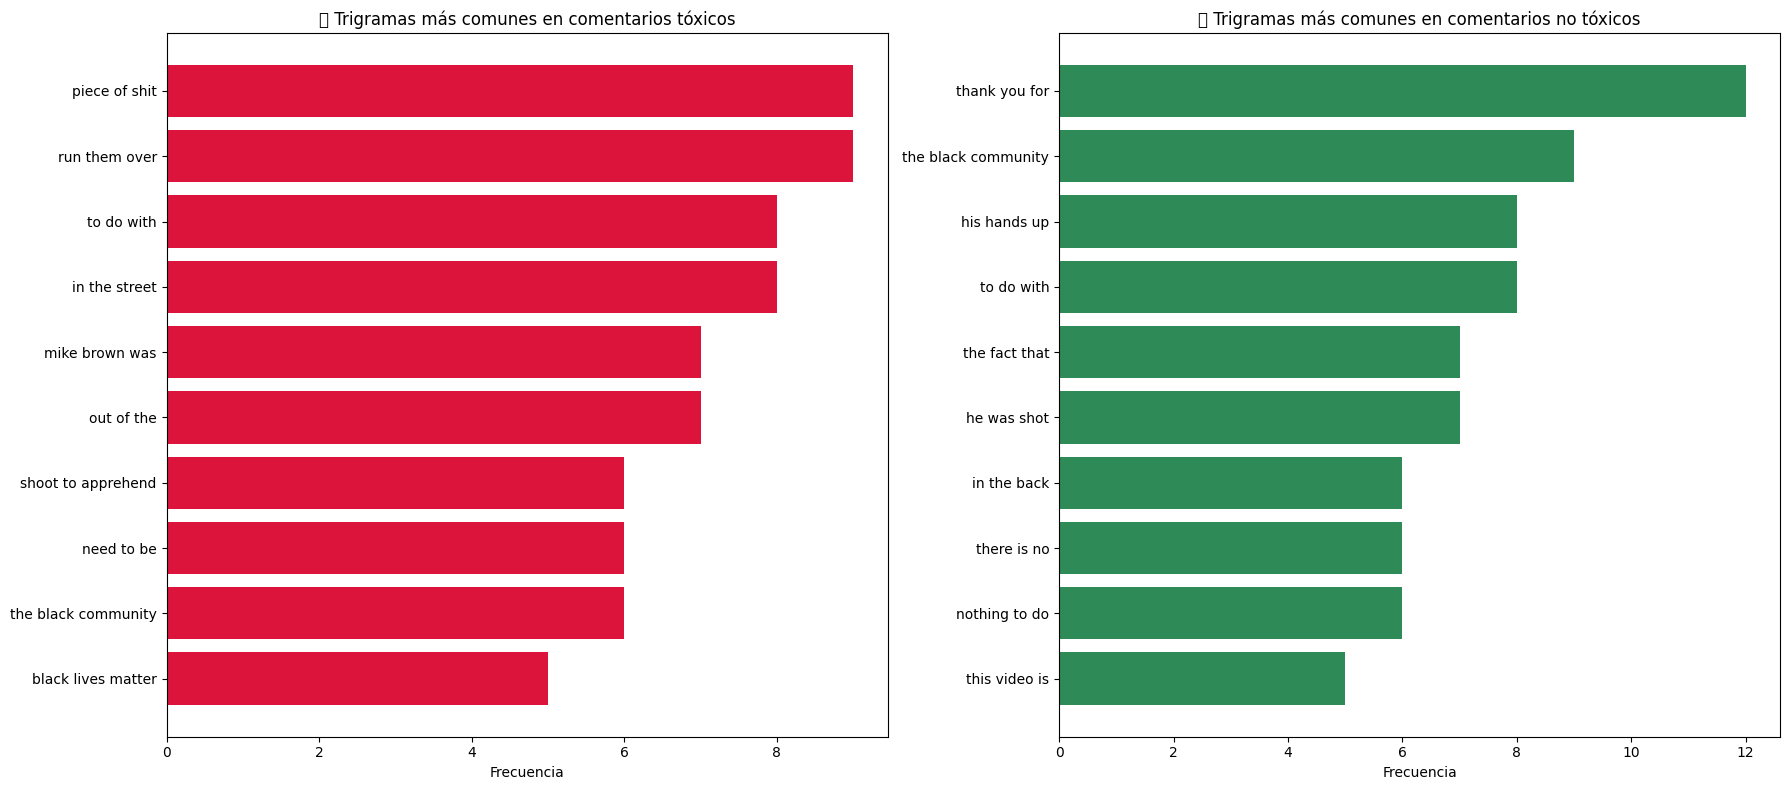

In [27]:
import matplotlib.pyplot as plt

# Extraer trigramas y frecuencias por separado
trigrams_tox, freqs_tox = zip(*top_trigrams_toxicos)
trigrams_notox, freqs_notox = zip(*top_trigrams_nontoxicos)

# Crear gráfico de barras horizontales
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Trigramas tóxicos
axes[0].barh(trigrams_tox[::-1], freqs_tox[::-1], color="crimson")
axes[0].set_title("🔴 Trigramas más comunes en comentarios tóxicos")
axes[0].set_xlabel("Frecuencia")
axes[0].tick_params(axis='y', labelsize=10)

# Trigramas no tóxicos
axes[1].barh(trigrams_notox[::-1], freqs_notox[::-1], color="seagreen")
axes[1].set_title("🟢 Trigramas más comunes en comentarios no tóxicos")
axes[1].set_xlabel("Frecuencia")
axes[1].tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()


### Visualización de trigramas más frecuentes

Los trigramas (combinaciones de tres palabras consecutivas) nos permiten observar expresiones completas y típicas de cada tipo de comentario.

#### 🔴 En los comentarios tóxicos:
- Aparecen insultos explícitos como **“piece of shit”**.
- Expresiones violentas como **“run them over”** o **“shoot to apprehend”**.
- Términos relacionados con movimientos sociales cargados emocionalmente: **“black lives matter”**.

#### 🟢 En los comentarios no tóxicos:
- Predominan expresiones de agradecimiento (**“thank you for”**) o frases explicativas/descriptivas.
- Se nota un tono más **objetivo, civil o analítico**.

Este contraste deja ver claramente cómo cambia la intención del lenguaje entre ambos grupos y valida el uso de trigramas como posibles características valiosas para entrenar el modelo de detección de toxicidad.


In [28]:
# Lista de etiquetas del dataset
etiquetas = [
    "IsToxic", "IsAbusive", "IsThreat", "IsProvocative", "IsObscene",
    "IsHatespeech", "IsRacist", "IsNationalist", "IsSexist", "IsHomophobic",
    "IsReligiousHate", "IsRadicalism"
]

# Calcular la correlación entre etiquetas
correlaciones = df[etiquetas].corr()

# Calcular cuántas etiquetas activas hay por comentario
df["TotalEtiquetas"] = df[etiquetas].sum(axis=1)
etiquetas_activas = df["TotalEtiquetas"].value_counts().sort_index()


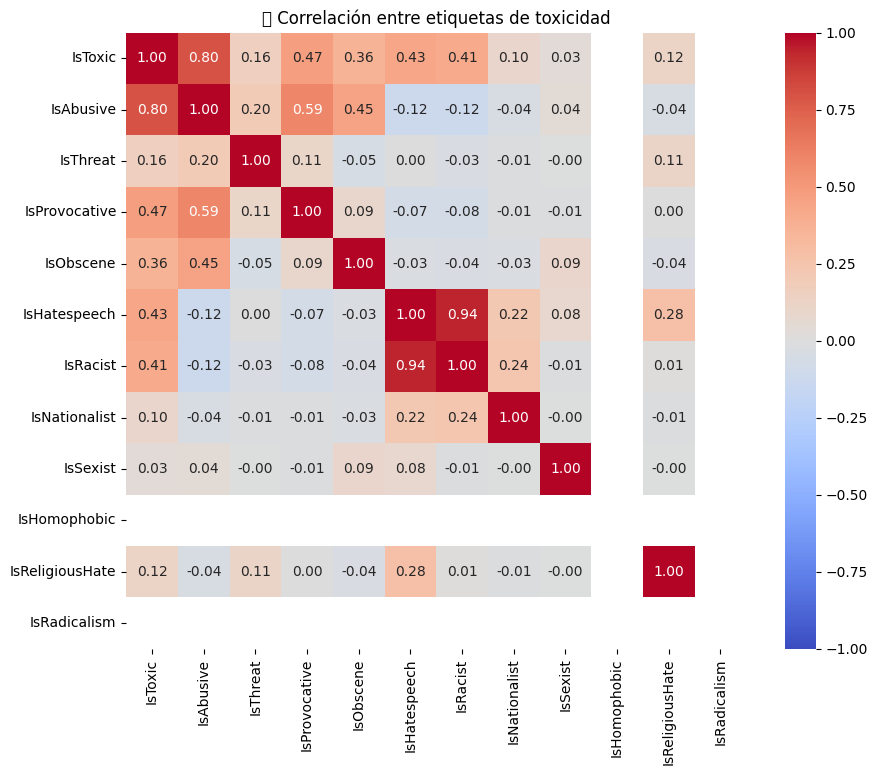

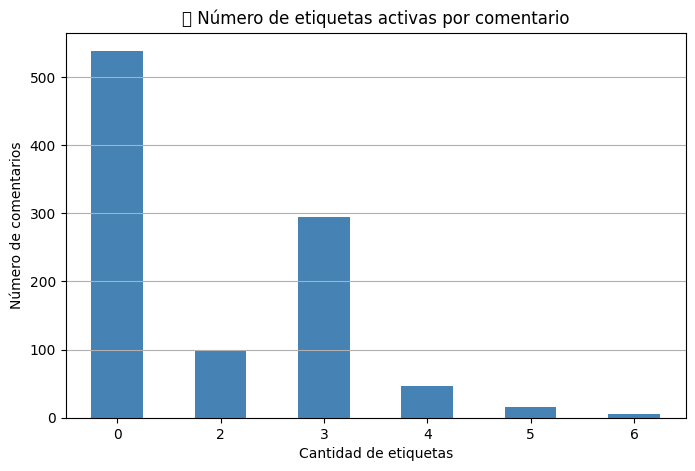

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualización de correlación entre etiquetas
plt.figure(figsize=(10, 8))
sns.heatmap(correlaciones, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("🔗 Correlación entre etiquetas de toxicidad")
plt.show()

# Visualización de número de etiquetas activas por comentario
etiquetas_activas.plot(kind="bar", color="steelblue", figsize=(8, 5))
plt.title("🎯 Número de etiquetas activas por comentario")
plt.xlabel("Cantidad de etiquetas")
plt.ylabel("Número de comentarios")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()


### ❗ Etiquetas sin representación en el dataset

Al analizar la correlación entre etiquetas de toxicidad, hemos detectado que algunas etiquetas como `IsHomophobic` y `IsRadicalism` **no presentan ninguna muestra positiva** en el dataset. Esto significa que:

- **No tenemos comentarios marcados con esas etiquetas.**
- **No es posible que el modelo aprenda a predecirlas correctamente**, ya que no tiene ejemplos.

#### ¿Qué implica esto?
- Estas etiquetas deberían ser **excluidas del modelado**, o tratadas específicamente si se tuviera acceso a datos adicionales.
- Incluirlas en un modelo supervisado causaría que el modelo siempre predijera "0" (ausencia), sin tener forma de corregirse.

Por tanto, en el preprocesamiento deberíamos filtrar automáticamente las etiquetas que no tengan representación para construir un modelo multietiqueta **robusto, explicable y realista**.


### Análisis cruzado de etiquetas

Además del análisis textual, es importante entender cómo se comportan las diferentes **subcategorías de toxicidad** que aparecen en el dataset (como `IsAbusive`, `IsThreat`, `IsRacist`, etc.).

#### ¿Cuántas etiquetas tiene cada comentario?

- Más de la mitad de los comentarios **no presentan ninguna etiqueta activa**.
- El resto puede tener múltiples etiquetas, lo que sugiere que **el problema podría ser tratado como multietiqueta** si quisiéramos predecir más allá de `IsToxic`.

#### ¿Qué etiquetas están relacionadas?

- `IsToxic` tiene una fuerte correlación con `IsAbusive` (**0.80**) y `IsProvocative`.
- `IsHatespeech` y `IsRacist` tienen una **correlación altísima** (**0.94**), lo que indica que suelen ir juntas.

Este análisis refuerza la idea de que la toxicidad **no es una dimensión única**, sino que puede tener varias expresiones combinadas. Si decidiéramos construir un modelo más complejo en el futuro, podríamos abordar este problema como una clasificación **multietiqueta** en lugar de binaria.


## 📚 Importación de Librerías

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Librerías para procesamiento de texto
import re
import string
from wordcloud import WordCloud

# Librerías de NLP
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

# Librerías de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Descargar recursos de NLTK necesarios
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/trabajo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/trabajo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/trabajo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/trabajo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Análisis de Texto

📝 ESTADÍSTICAS DE TEXTO:
Longitud promedio: 185.6 caracteres
Longitud mediana: 101.0 caracteres
Longitud mínima: 3 caracteres
Longitud máxima: 4421 caracteres
Palabras promedio: 33.8


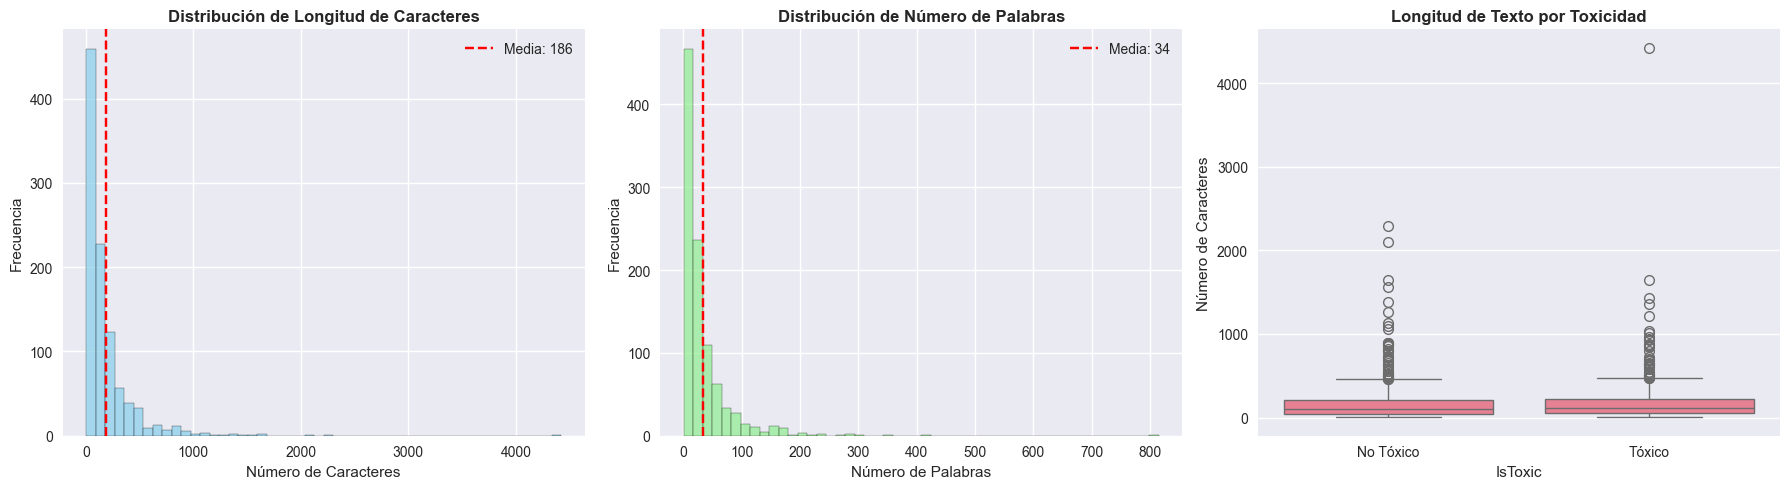

In [31]:
# Estadísticas de longitud de texto
df['text_length'] = df['Text'].str.len()
df['word_count'] = df['Text'].str.split().str.len()

# Estadísticas descriptivas
print("📝 ESTADÍSTICAS DE TEXTO:")
print("=" * 40)
print(f"Longitud promedio: {df['text_length'].mean():.1f} caracteres")
print(f"Longitud mediana: {df['text_length'].median():.1f} caracteres")
print(f"Longitud mínima: {df['text_length'].min()} caracteres")
print(f"Longitud máxima: {df['text_length'].max()} caracteres")
print(f"Palabras promedio: {df['word_count'].mean():.1f}")

# Visualización de distribuciones
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histograma de longitud de caracteres
axes[0].hist(df['text_length'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Distribución de Longitud de Caracteres', fontweight='bold')
axes[0].set_xlabel('Número de Caracteres')
axes[0].set_ylabel('Frecuencia')
axes[0].axvline(df['text_length'].mean(), color='red', linestyle='--', label=f'Media: {df["text_length"].mean():.0f}')
axes[0].legend()

# Histograma de número de palabras
axes[1].hist(df['word_count'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1].set_title('Distribución de Número de Palabras', fontweight='bold')
axes[1].set_xlabel('Número de Palabras')
axes[1].set_ylabel('Frecuencia')
axes[1].axvline(df['word_count'].mean(), color='red', linestyle='--', label=f'Media: {df["word_count"].mean():.0f}')
axes[1].legend()

# Boxplot comparativo por toxicidad
df_plot = df[['text_length', 'IsToxic']].copy()
df_plot['IsToxic'] = df_plot['IsToxic'].map({True: 'Tóxico', False: 'No Tóxico'})
sns.boxplot(data=df_plot, x='IsToxic', y='text_length', ax=axes[2])
axes[2].set_title('Longitud de Texto por Toxicidad', fontweight='bold')
axes[2].set_ylabel('Número de Caracteres')

plt.tight_layout()
plt.show()

**Longitud de texto:**

- Los comentarios tóxicos pueden tener patrones de longitud diferentes
- **Distribución:** Entender la variabilidad en el dataset
- **Comparación por toxicidad:** Ver si hay diferencias en longitud entre comentarios tóxicos y no tóxicos

### Análisis de Correlaciones

🔍 ANÁLISIS DE VARIABILIDAD:
✅ IsToxic         - Valores únicos: [False  True], Varianza: 0.2488
✅ IsAbusive       - Valores únicos: [False  True], Varianza: 0.2286
✅ IsThreat        - Valores únicos: [False  True], Varianza: 0.0206
✅ IsProvocative   - Valores únicos: [False  True], Varianza: 0.1352
✅ IsObscene       - Valores únicos: [False  True], Varianza: 0.0901
✅ IsHatespeech    - Valores únicos: [False  True], Varianza: 0.1191
✅ IsRacist        - Valores únicos: [False  True], Varianza: 0.1095
✅ IsNationalist   - Valores únicos: [False  True], Varianza: 0.0079
✅ IsSexist        - Valores únicos: [False  True], Varianza: 0.0010
❌ IsHomophobic    - Solo tiene: [False], Varianza: 0.0000
✅ IsReligiousHate - Valores únicos: [False  True], Varianza: 0.0119
❌ IsRadicalism    - Solo tiene: [False], Varianza: 0.0000

📊 Variables con variación: 10
🚫 Variables constantes: 2

Variables constantes (no se pueden correlacionar): IsHomophobic, IsRadicalism


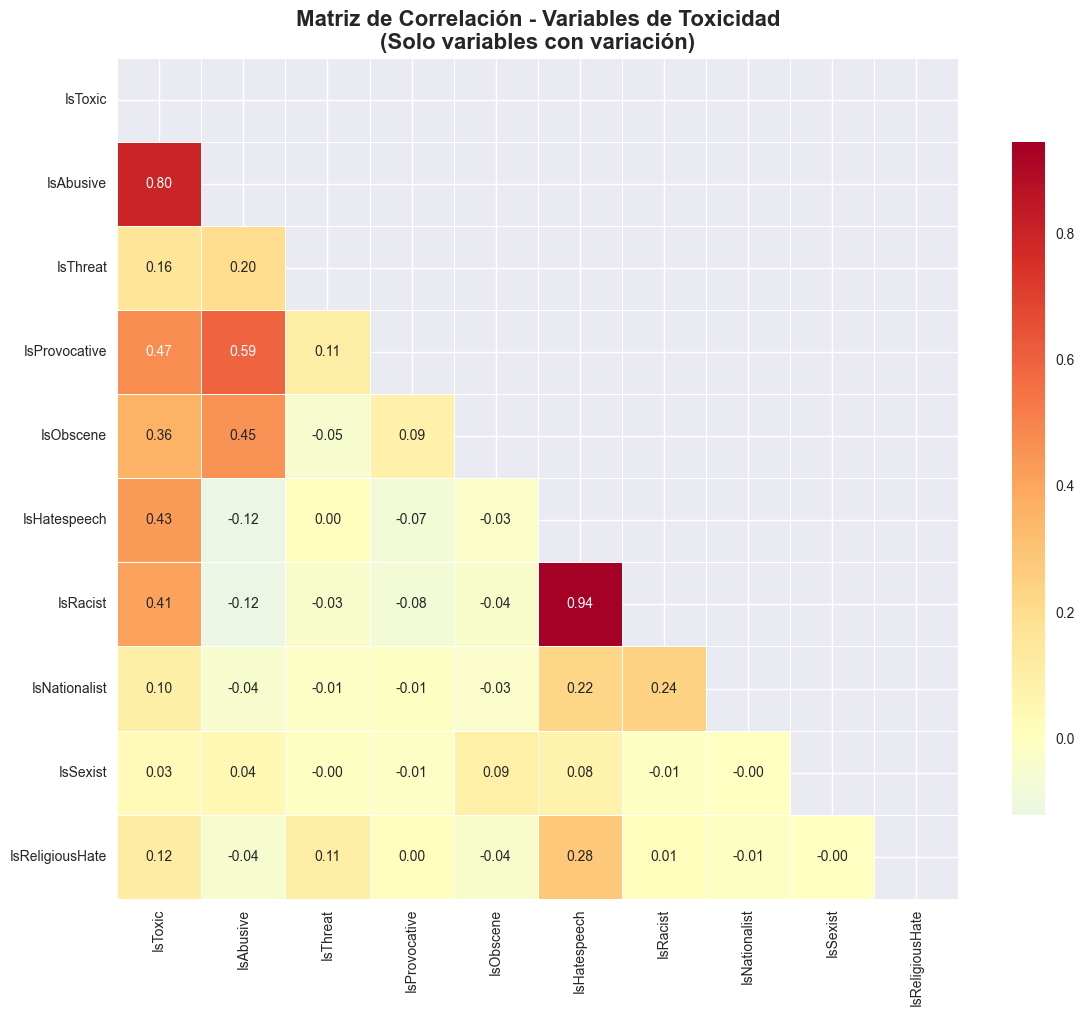


🔗 CORRELACIONES MÁS ALTAS:
 1. IsHatespeech ↔ IsRacist:  0.945 🔴 Fuerte
 2. IsToxic ↔ IsAbusive:  0.797 🔴 Fuerte
 3. IsAbusive ↔ IsProvocative:  0.593 🟡 Moderada
 4. IsToxic ↔ IsProvocative:  0.473 🟡 Moderada
 5. IsAbusive ↔ IsObscene:  0.451 🟡 Moderada
 6. IsToxic ↔ IsHatespeech:  0.432 🟡 Moderada
 7. IsToxic ↔ IsRacist:  0.408 🟡 Moderada
 8. IsToxic ↔ IsObscene:  0.360 🟡 Moderada
 9. IsHatespeech ↔ IsReligiousHate:  0.275 🟢 Débil
10. IsRacist ↔ IsNationalist:  0.238 🟢 Débil

📊 RESUMEN ESTADÍSTICO:
Total de correlaciones calculadas: 45
Correlación promedio (valor absoluto): 0.158
Correlación más alta: 0.945
Correlación más baja: 0.002

Distribución por fuerza:
  🔴 Correlaciones fuertes (≥0.7): 2
  🟡 Correlaciones moderadas (0.3-0.7): 6
  🟢 Correlaciones débiles (<0.3): 37

📋 RESUMEN COMPLETO DE VARIABLES:
📊 Variable | IsToxic         | Sí: 462 ( 46.2%) | No: 538 ( 53.8%)
📊 Variable | IsAbusive       | Sí: 353 ( 35.3%) | No: 647 ( 64.7%)
📊 Variable | IsThreat        | Sí:  21 (  2.1%)

In [32]:
toxicity_columns = [
    'IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene',
    'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist',
    'IsHomophobic', 'IsReligiousHate', 'IsRadicalism'
]

# Analizar variabilidad de cada columna
print("🔍 ANÁLISIS DE VARIABILIDAD:")
print("=" * 60)
variable_columns = []
constant_columns = []

for col in toxicity_columns:
    unique_vals = df[col].unique()
    variance = df[col].var()
    
    if len(unique_vals) > 1 and variance > 0:
        variable_columns.append(col)
        print(f"✅ {col:15} - Valores únicos: {unique_vals}, Varianza: {variance:.4f}")
    else:
        constant_columns.append(col)
        print(f"❌ {col:15} - Solo tiene: {unique_vals}, Varianza: {variance:.4f}")

print(f"\n📊 Variables con variación: {len(variable_columns)}")
print(f"🚫 Variables constantes: {len(constant_columns)}")

if constant_columns:
    print(f"\nVariables constantes (no se pueden correlacionar): {', '.join(constant_columns)}")

# Matriz de correlación solo para variables con variación
if len(variable_columns) >= 2:
    correlation_matrix = df[variable_columns].corr()
    
    # Visualización mejorada
    plt.figure(figsize=(12, 10))
    
    # Crear máscara triangular superior
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Crear heatmap
    sns.heatmap(correlation_matrix,
                mask=mask,
                annot=True,
                cmap='RdYlBu_r',
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={"shrink": .8},
                linewidths=0.5)
    
    plt.title('Matriz de Correlación - Variables de Toxicidad\n(Solo variables con variación)', 
              fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    #Top correlaciones
    print("\n🔗 CORRELACIONES MÁS ALTAS:")
    print("=" * 50)
    
    # Crear lista de correlaciones (excluyendo diagonal)
    correlations = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if not np.isnan(corr_value):  # Excluir NaN
                correlations.append((correlation_matrix.columns[i], 
                                   correlation_matrix.columns[j], corr_value))
    
    # Ordenar por valor absoluto de correlación
    correlations.sort(key=lambda x: abs(x[2]), reverse=True)
    
    # Mostrar correlaciones
    for i, (var1, var2, corr) in enumerate(correlations[:10], 1):
        strength = "🔴 Fuerte" if abs(corr) >= 0.7 else "🟡 Moderada" if abs(corr) >= 0.3 else "🟢 Débil"
        print(f"{i:2d}. {var1} ↔ {var2}: {corr:6.3f} {strength}")
    
    # Resumen estadístico
    print(f"\n📊 RESUMEN ESTADÍSTICO:")
    print("=" * 50)
    print(f"Total de correlaciones calculadas: {len(correlations)}")
    
    if correlations:
        correlations_values = [abs(corr[2]) for corr in correlations]
        print(f"Correlación promedio (valor absoluto): {np.mean(correlations_values):.3f}")
        print(f"Correlación más alta: {max(correlations_values):.3f}")
        print(f"Correlación más baja: {min(correlations_values):.3f}")
        
        # Contar por fuerza
        strong = sum(1 for corr in correlations_values if corr >= 0.7)
        moderate = sum(1 for corr in correlations_values if 0.3 <= corr < 0.7)
        weak = sum(1 for corr in correlations_values if corr < 0.3)
        
        print(f"\nDistribución por fuerza:")
        print(f"  🔴 Correlaciones fuertes (≥0.7): {strong}")
        print(f"  🟡 Correlaciones moderadas (0.3-0.7): {moderate}")
        print(f"  🟢 Correlaciones débiles (<0.3): {weak}")

else:
    print("❌ No hay suficientes variables con variación para calcular correlaciones")

# Tabla resumen de todas las variables
print(f"\n📋 RESUMEN COMPLETO DE VARIABLES:")
print("=" * 70)
for col in toxicity_columns:
    true_count = df[col].sum()
    false_count = len(df) - true_count
    true_pct = (true_count / len(df)) * 100
    
    # Indicar estado
    if col in variable_columns:
        status = "📊 Variable"
    else:
        status = "⚠️  Constante"
    
    print(f"{status} | {col:15} | Sí: {true_count:3d} ({true_pct:5.1f}%) | No: {false_count:3d} ({100-true_pct:5.1f}%)")

## 🧹 Preprocesamiento de Datos
### Limpieza Básica de Texto

In [33]:
def clean_text_basic(text):
    """
    Limpieza básica de texto
    - Convierte a minúsculas
    - Elimina caracteres especiales
    - Elimina espacios extra
    """
    if pd.isna(text):
        return ""
    
    # Convertir a string y minúsculas
    text = str(text).lower()
    
    # Eliminar URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Eliminar menciones y hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Eliminar números
    text = re.sub(r'\d+', '', text)
    
    # Eliminar caracteres especiales pero mantener espacios
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Eliminar espacios múltiples
    text = re.sub(r'\s+', ' ', text)
    
    # Eliminar espacios al inicio y final
    text = text.strip()
    
    return text

# Aplicar limpieza básica
df['text_cleaned'] = df['Text'].apply(clean_text_basic)

# Mostrar ejemplos de limpieza
print("🧹 EJEMPLOS DE LIMPIEZA BÁSICA:")
print("=" * 50)
for i in range(3):
    print(f"Original: {df['Text'].iloc[i][:100]}...")
    print(f"Limpio:   {df['text_cleaned'].iloc[i][:100]}...")
    print("-" * 50)

🧹 EJEMPLOS DE LIMPIEZA BÁSICA:
Original: If only people would just take a step back and not make this case about them, because it wasn't abou...
Limpio:   if only people would just take a step back and not make this case about them because it wasnt about ...
--------------------------------------------------
Original: Law enforcement is not trained to shoot to apprehend.  They are trained to shoot to kill.  And I tha...
Limpio:   law enforcement is not trained to shoot to apprehend they are trained to shoot to kill and i thank w...
--------------------------------------------------
Original: 
Dont you reckon them 'black lives matter' banners being held by white cunts is  kinda patronizing a...
Limpio:   dont you reckon them black lives matter banners being held by white cunts is kinda patronizing and i...
--------------------------------------------------


**¿Por qué esta limpieza?**

 - **URLs y menciones:** No aportan valor semántico para clasificación
 - **Números:** Generalmente no son relevantes para toxicidad
 - **Caracteres especiales:** Pueden introducir ruido en el modelo
 - **Normalización:** Minúsculas para consistencia

### Eliminación de Stopwords

In [34]:
# Cargar stopwords en inglés
stop_words = set(stopwords.words('english'))

# Añadir stopwords personalizadas si es necesario
custom_stopwords = {'youtube', 'video', 'comment', 'like', 'subscribe'}
stop_words.update(custom_stopwords)

def remove_stopwords(text):
    """Eliminar stopwords del texto"""
    if not text:
        return ""
    
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Aplicar eliminación de stopwords
df['text_no_stopwords'] = df['text_cleaned'].apply(remove_stopwords)

# Comparar antes y después
print("🚫 EJEMPLOS DE ELIMINACIÓN DE STOPWORDS:")
print("=" * 50)
for i in range(3):
    print(f"Con stopwords:    {df['text_cleaned'].iloc[i][:100]}...")
    print(f"Sin stopwords:    {df['text_no_stopwords'].iloc[i][:100]}...")
    print("-" * 50)

# Estadísticas de reducción
original_words = df['text_cleaned'].str.split().str.len().sum()
filtered_words = df['text_no_stopwords'].str.split().str.len().sum()
reduction = ((original_words - filtered_words) / original_words) * 100

print(f"📊 REDUCCIÓN DE PALABRAS:")
print(f"Palabras originales: {original_words:,}")
print(f"Palabras filtradas: {filtered_words:,}")
print(f"Reducción: {reduction:.1f}%")

🚫 EJEMPLOS DE ELIMINACIÓN DE STOPWORDS:
Con stopwords:    if only people would just take a step back and not make this case about them because it wasnt about ...
Sin stopwords:    people would take step back make case wasnt anyone except two people situation lump mess take matter...
--------------------------------------------------
Con stopwords:    law enforcement is not trained to shoot to apprehend they are trained to shoot to kill and i thank w...
Sin stopwords:    law enforcement trained shoot apprehend trained shoot kill thank wilson killing punk bitch...
--------------------------------------------------
Con stopwords:    dont you reckon them black lives matter banners being held by white cunts is kinda patronizing and i...
Sin stopwords:    dont reckon black lives matter banners held white cunts kinda patronizing ironically racist could co...
--------------------------------------------------
📊 REDUCCIÓN DE PALABRAS:
Palabras originales: 33,252
Palabras filtradas: 17,066
Reduc

**¿Por qué eliminar stopwords?**

 - **Ruido:** Palabras como "the", "and", "is" no aportan significado
 - **Eficiencia:** Reduce dimensionalidad del vector de características
 - **Enfoque:** Permite al modelo centrarse en palabras con contenido semántico

### Stemming y Lemmatización

In [35]:
# Inicializar herramientas
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def apply_stemming(text):
    """Aplicar stemming usando Porter Stemmer"""
    if not text:
        return ""
    
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

def apply_lemmatization(text):
    """Aplicar lemmatización usando WordNet"""
    if not text:
        return ""
    
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Aplicar tanto stemming como lemmatización
df['text_stemmed'] = df['text_no_stopwords'].apply(apply_stemming)
df['text_lemmatized'] = df['text_no_stopwords'].apply(apply_lemmatization)

# Comparar los métodos
print("🔤 COMPARACIÓN: STEMMING VS LEMMATIZACIÓN")
print("=" * 60)
sample_text = "running runs ran runner easily fairly"
print(f"Texto original: {sample_text}")
print(f"Stemming:       {apply_stemming(sample_text)}")
print(f"Lemmatización:  {apply_lemmatization(sample_text)}")

print("\n📝 EJEMPLOS EN EL DATASET:")
for i in range(2):
    print(f"\nEjemplo {i+1}:")
    print(f"Original:     {df['text_no_stopwords'].iloc[i][:80]}...")
    print(f"Stemming:     {df['text_stemmed'].iloc[i][:80]}...")
    print(f"Lemmatizado:  {df['text_lemmatized'].iloc[i][:80]}...")

🔤 COMPARACIÓN: STEMMING VS LEMMATIZACIÓN
Texto original: running runs ran runner easily fairly
Stemming:       run run ran runner easili fairli
Lemmatización:  running run ran runner easily fairly

📝 EJEMPLOS EN EL DATASET:

Ejemplo 1:
Original:     people would take step back make case wasnt anyone except two people situation l...
Stemming:     peopl would take step back make case wasnt anyon except two peopl situat lump me...
Lemmatizado:  people would take step back make case wasnt anyone except two people situation l...

Ejemplo 2:
Original:     law enforcement trained shoot apprehend trained shoot kill thank wilson killing ...
Stemming:     law enforc train shoot apprehend train shoot kill thank wilson kill punk bitch...
Lemmatizado:  law enforcement trained shoot apprehend trained shoot kill thank wilson killing ...


### ¿Stemming vs Lemmatización?

 - **Stemming:** Más rápido, corta palabras a su raíz (running → run)
 - **Lemmatización:** Más preciso, considera contexto gramatical (better → good)
 - **Para este proyecto:** Usaremos ambos y compararemos rendimiento

### Análisis de Palabras Más Frecuentes

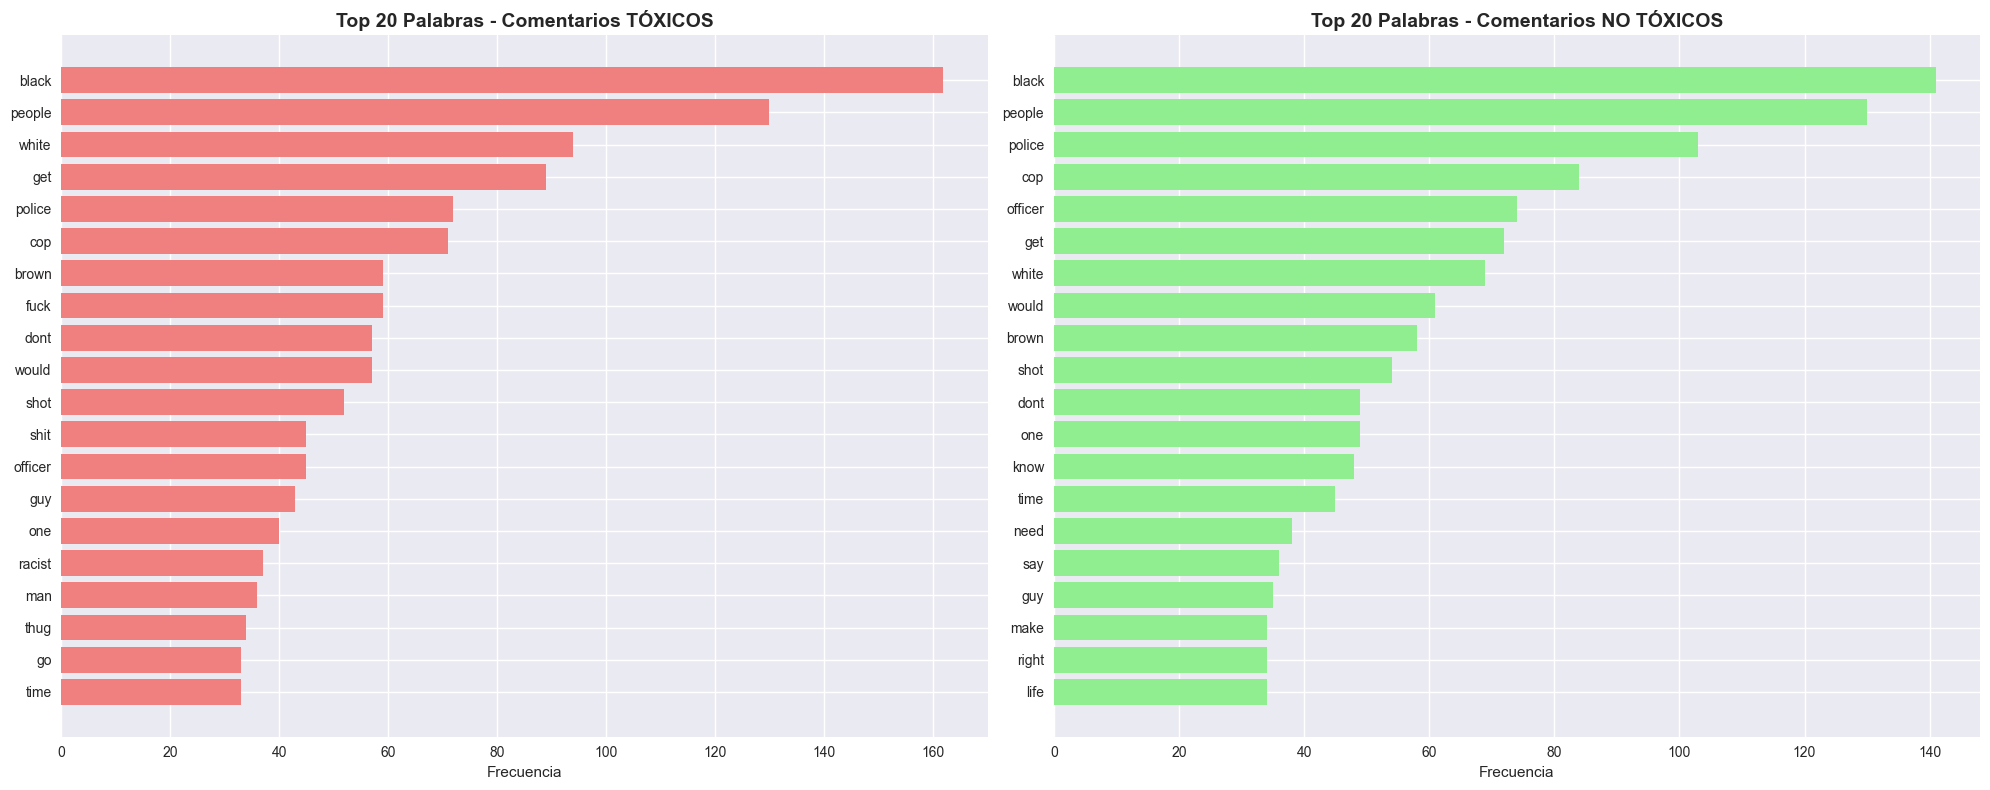

🔥 TOP 10 PALABRAS EN COMENTARIOS TÓXICOS:
  black: 162
  people: 130
  white: 94
  get: 89
  police: 72
  cop: 71
  brown: 59
  fuck: 59
  dont: 57
  would: 57

✅ TOP 10 PALABRAS EN COMENTARIOS NO TÓXICOS:
  black: 141
  people: 130
  police: 103
  cop: 84
  officer: 74
  get: 72
  white: 69
  would: 61
  brown: 58
  shot: 54


In [36]:
from collections import Counter

def get_word_frequency(text_series, top_n=20):
    """Obtener las palabras más frecuentes"""
    all_words = []
    for text in text_series:
        if text:
            all_words.extend(text.split())
    return Counter(all_words).most_common(top_n)

# Analizar palabras más frecuentes por categoría
toxic_texts = df[df['IsToxic'] == True]['text_lemmatized']
non_toxic_texts = df[df['IsToxic'] == False]['text_lemmatized']

toxic_words = get_word_frequency(toxic_texts, 20)
non_toxic_words = get_word_frequency(non_toxic_texts, 20)

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Palabras en comentarios tóxicos
words_t, counts_t = zip(*toxic_words)
axes[0].barh(range(len(words_t)), counts_t, color='lightcoral')
axes[0].set_yticks(range(len(words_t)))
axes[0].set_yticklabels(words_t)
axes[0].set_title('Top 20 Palabras - Comentarios TÓXICOS', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Frecuencia')
axes[0].invert_yaxis()

# Palabras en comentarios no tóxicos
words_nt, counts_nt = zip(*non_toxic_words)
axes[1].barh(range(len(words_nt)), counts_nt, color='lightgreen')
axes[1].set_yticks(range(len(words_nt)))
axes[1].set_yticklabels(words_nt)
axes[1].set_title('Top 20 Palabras - Comentarios NO TÓXICOS', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Frecuencia')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("🔥 TOP 10 PALABRAS EN COMENTARIOS TÓXICOS:")
for word, count in toxic_words[:10]:
    print(f"  {word}: {count}")

print("\n✅ TOP 10 PALABRAS EN COMENTARIOS NO TÓXICOS:")
for word, count in non_toxic_words[:10]:
    print(f"  {word}: {count}")

### Generación de WordClouds

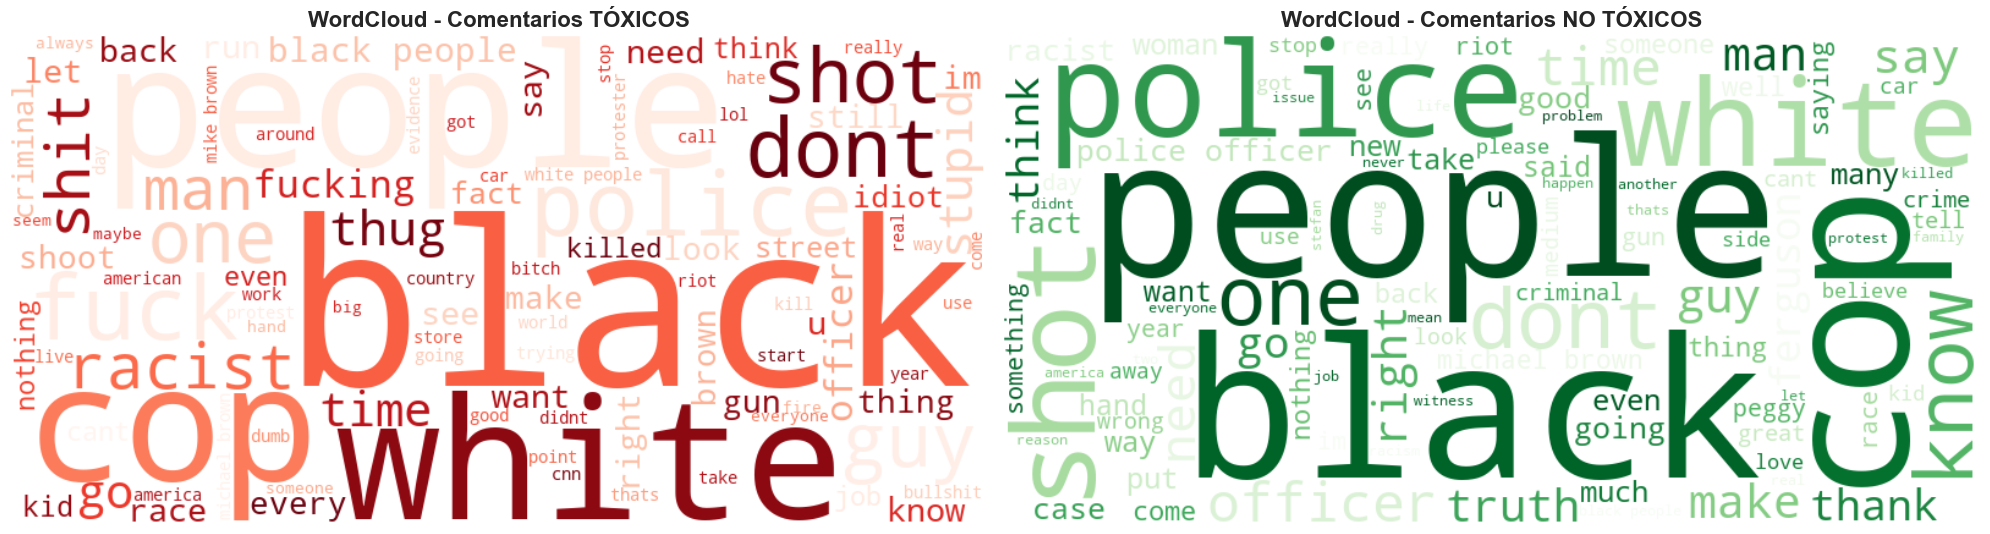

In [37]:
# Combinar textos por categoría
toxic_text_combined = ' '.join(toxic_texts.dropna())
non_toxic_text_combined = ' '.join(non_toxic_texts.dropna())

# Generar WordClouds
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# WordCloud para comentarios tóxicos
wordcloud_toxic = WordCloud(width=800, height=400, 
                           background_color='white',
                           colormap='Reds',
                           max_words=100).generate(toxic_text_combined)

axes[0].imshow(wordcloud_toxic, interpolation='bilinear')
axes[0].set_title('WordCloud - Comentarios TÓXICOS', fontweight='bold', fontsize=16)
axes[0].axis('off')

# WordCloud para comentarios no tóxicos
wordcloud_non_toxic = WordCloud(width=800, height=400,
                                background_color='white',
                                colormap='Greens',
                                max_words=100).generate(non_toxic_text_combined)

axes[1].imshow(wordcloud_non_toxic, interpolation='bilinear')
axes[1].set_title('WordCloud - Comentarios NO TÓXICOS', fontweight='bold', fontsize=16)
axes[1].axis('off')

plt.tight_layout()
plt.show()

**¿Por qué este análisis?**

 - **Patrones léxicos:** Identificar palabras características de cada clase
 - **WordClouds:** Visualización intuitiva de términos importantes
 - **Feature engineering:** Basis para crear características específicas

## ⚙️ Vectorización de Texto

### TF-IDF (Term Frequency-Inverse Document Frequency)

In [38]:
# Preparar diferentes versiones del texto
text_versions = {
    'cleaned': df['text_cleaned'],
    'no_stopwords': df['text_no_stopwords'],
    'stemmed': df['text_stemmed'],
    'lemmatized': df['text_lemmatized']
}

# Configurar TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,          # Top 5000 características
    min_df=2,                   # Palabra debe aparecer en al menos 2 documentos
    max_df=0.95,                # Palabra no debe aparecer en más del 95% de documentos
    ngram_range=(1, 2),         # Unigramas y bigramas
    stop_words='english'        # Stopwords adicionales
)

# Vectorizar texto lemmatizado (mejor balance precisión-velocidad)
X_tfidf = tfidf_vectorizer.fit_transform(df['text_lemmatized'].fillna(''))
y = df['IsToxic'].astype(int)

print("🔤 INFORMACIÓN DE VECTORIZACIÓN TF-IDF:")
print("=" * 50)
print(f"Forma de la matriz: {X_tfidf.shape}")
print(f"Número de características: {len(tfidf_vectorizer.get_feature_names_out())}")
print(f"Sparsity: {(1 - X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1])):.4f}")

# Top características TF-IDF
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = X_tfidf.toarray().mean(axis=0)
top_features = sorted(zip(feature_names, tfidf_scores), key=lambda x: x[1], reverse=True)

print(f"\n🏆 TOP 15 CARACTERÍSTICAS TF-IDF:")
for feature, score in top_features[:15]:
    print(f"  {feature}: {score:.4f}")

🔤 INFORMACIÓN DE VECTORIZACIÓN TF-IDF:
Forma de la matriz: (1000, 2197)
Número de características: 2197
Sparsity: 0.9942

🏆 TOP 15 CARACTERÍSTICAS TF-IDF:
  people: 0.0307
  black: 0.0301
  police: 0.0215
  cop: 0.0186
  white: 0.0185
  run: 0.0155
  guy: 0.0154
  brown: 0.0148
  dont: 0.0139
  shot: 0.0135
  racist: 0.0128
  officer: 0.0124
  time: 0.0117
  fuck: 0.0117
  need: 0.0112


**¿Por qué TF-IDF?**

- **TF (Term Frequency):** Importancia de la palabra en el documento
- **IDF (Inverse Document Frequency):** Reduce peso de palabras muy comunes
- **Resultado:** Palabras discriminativas obtienen mayor peso

### Bag of Words (CountVectorizer)

In [39]:
# Configurar CountVectorizer
count_vectorizer = CountVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 2),
    stop_words='english'
)

# Vectorizar
X_count = count_vectorizer.fit_transform(df['text_lemmatized'].fillna(''))

print("🔢 INFORMACIÓN DE VECTORIZACIÓN BAG OF WORDS:")
print("=" * 50)
print(f"Forma de la matriz: {X_count.shape}")
print(f"Número de características: {len(count_vectorizer.get_feature_names_out())}")
print(f"Sparsity: {(1 - X_count.nnz / (X_count.shape[0] * X_count.shape[1])):.4f}")

🔢 INFORMACIÓN DE VECTORIZACIÓN BAG OF WORDS:
Forma de la matriz: (1000, 2197)
Número de características: 2197
Sparsity: 0.9942


**¿Bag of Words vs TF-IDF?**

- **Bag of Words:** Cuenta simple de frecuencias
- **TF-IDF:** Normaliza por importancia en el corpus
- **Para toxicidad:** TF-IDF suele funcionar mejor